# WDWY MTA Turnstile Analysis 

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [2]:
engine = create_engine("sqlite:///mta_data.db")

insp = inspect(engine)
print(insp.get_table_names())
print(insp.get_columns('mta_data'))
print(engine.table_names())

['mta_data']
[{'name': 'C/A', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UNIT', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'SCP', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'STATION', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'LINENAME', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'DIVISION', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'DATE', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'TIME', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'DESC', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincremen

<ipython-input-2-8d6478e143f3>:6: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


Understand how many total stations there are. We're trying to glean which fields can stand alone and truly show the volume in a single area. 

## Initial SQL Exploration

In [3]:
pd.read_sql('SELECT COUNT(DISTINCT STATION)FROM mta_data;', engine)

COUNT(DISTINCT STATION)
0                      379

In [4]:
pd.read_sql('SELECT STATION, UNIT, COUNT(DISTINCT SCP) FROM mta_data WHERE STATION = "59 ST" ;', engine)

STATION  UNIT  COUNT(DISTINCT SCP)
0   59 ST  R051                   34

It looks like in a single station, you can have at least 34 SCPs. That granularity (the SCP level) doesn't appeal to us. 

In [5]:
pd.read_sql('SELECT STATION, COUNT(DISTINCT "C/A"), COUNT(DISTINCT LINENAME), COUNT(DISTINCT UNIT), COUNT(DISTINCT SCP) FROM mta_data GROUP BY STATION ORDER BY COUNT(DISTINCT SCP) DESC;', engine)

STATION  COUNT(DISTINCT "C/A")  COUNT(DISTINCT LINENAME)  \
0          FULTON ST                     12                         3   
1     34 ST-PENN STA                     13                         3   
2    GRD CNTRL-42 ST                      8                         1   
3     ATL AV-BARCLAY                      3                         2   
4        CHAMBERS ST                      5                         3   
..               ...                    ...                       ...   
374           190 ST                      1                         1   
375      182-183 STS                      1                         1   
376   138/GRAND CONC                      1                         1   
377        SUTTER AV                      1                         1   
378     CLEVELAND ST                      1                         1   

     COUNT(DISTINCT UNIT)  COUNT(DISTINCT SCP)  
0                       3                   80  
1                       4                   63  
2                       4                   54  
3                       1                   52  
4                       3                   50  
..                    ...                  ...  
374                     1                    3  
375                     1                    3  
376                     1                    3  
377                     1                    2  
378                     1                    2  

[379 rows x 5 columns]

Looking more closely, many stations have multiple C/As, Line names, and units, and ALL stations have at least 2 distinct turnstiles (SCPs). This makes me think we should get ridership data from each SCP and then aggregate it to the station level. However, in doing so we may lose some of the granularity in the line names. Not sure if we need that?

In [6]:
pd.read_sql('SELECT STATION, COUNT(DISTINCT LINENAME) FROM mta_data GROUP BY STATION HAVING COUNT(DISTINCT LINENAME)>1 ORDER BY COUNT(DISTINCT LINENAME) DESC;', engine)

STATION  COUNT(DISTINCT LINENAME)
0             86 ST                         5
1             23 ST                         5
2            125 ST                         4
3    TIMES SQ-42 ST                         3
4         KINGS HWY                         3
..              ...                       ...
65  161/YANKEE STAD                         2
66           155 ST                         2
67   14 ST-UNION SQ                         2
68           135 ST                         2
69           104 ST                         2

[70 rows x 2 columns]

70 stations have more than one line name. Here's an example: 

In [7]:
pd.read_sql('SELECT DISTINCT LINENAME FROM mta_data WHERE STATION = "86 ST";', engine)

LINENAME
0        R
1        N
2       BC
3        1
4      456

Maybe for every station I should add all of the possible linenames into one string just to have them. 

In [8]:
pd.read_sql('SELECT STATION, COUNT(STATION) FROM mta_data GROUP BY STATION ORDER BY COUNT(STATION) DESC;', engine)

STATION  COUNT(STATION)
0     34 ST-PENN STA          153853
1          FULTON ST          145039
2    GRD CNTRL-42 ST          134978
3              23 ST          110397
4              86 ST           98299
..               ...             ...
374    CYPRESS HILLS            4513
375      182-183 STS            4510
376     CLEVELAND ST            3022
377        SUTTER AV            3015
378    ORCHARD BEACH            2668

[379 rows x 2 columns]

## Moving into Pandas Here

In [9]:
df = pd.read_sql("""SELECT "C/A", UNIT, SCP, STATION, LINENAME, DATE, TIME, DESC, ENTRIES, EXITS 
                        FROM mta_data WHERE DATE NOT LIKE "%2020"
                        ORDER BY STATION,UNIT, SCP, DATE, TIME;""", engine)

In [10]:
pd.options.display.max_rows = 200
df.sample(50)

C/A  UNIT       SCP          STATION      LINENAME        DATE  \
4283431   R621  R060  00-00-00  EASTN PKWY-MUSM            23  07/07/2021   
5207773  N002A  R173  00-00-02    INWOOD-207 ST             A  05/21/2021   
6671952   R101  R001  02-00-00      SOUTH FERRY           1RW  06/24/2021   
5725860   N125  R440  00-00-02       LIBERTY AV             C  03/23/2021   
1641123   R520  R223  01-05-00   46 ST BLISS ST             7  04/21/2021   
3116875   C023  R213  00-03-02     BAY RIDGE AV             R  04/27/2021   
668061    N208  R443  01-00-02           170 ST            BD  05/03/2021   
3452471   A084  R125  01-03-01         BROAD ST            JZ  01/17/2021   
429181    N019  R101  01-00-01           145 ST          ABCD  04/08/2021   
5108941   R121  R290  01-06-01       HOUSTON ST             1  03/22/2021   
2807672   R219  R160  00-00-03         ASTOR PL             6  01/13/2021   
4962193   N405  R239  00-00-02    GREENPOINT AV             G  06/07/2021   
855426    R333  R366  00-00-00           225 ST            25  05/19/2021   
3008069   N554  R423  01-06-01         AVENUE N             F  01/04/2021   
7036409   R503  R276  01-00-00   VERNON-JACKSON             7  03/18/2021   
1257336   R550  R072  00-03-06  34 ST-HUDSON YD             7  02/15/2021   
2094843   N049  R084  01-03-00   59 ST COLUMBUS         ABCD1  03/17/2021   
3104882   N553  R422  00-00-00         BAY PKWY             F  05/07/2021   
4578366   K025  R404  00-00-01    FRESH POND RD             M  08/31/2021   
2957795   N551  R421  00-00-00         AVENUE I             F  01/13/2021   
999104    E015  R399  00-00-00            25 AV             D  08/29/2021   
1007348   C017  R455  00-00-00            25 ST             R  05/19/2021   
3575354   N090  R139  01-05-00         CANAL ST           ACE  02/24/2021   
6914212   R143  R032  02-03-01   TIMES SQ-42 ST  1237ACENQRSW  01/15/2021   
83171     N137  R354  00-06-01           104 ST             A  02/16/2021   
449909    R261  R205  00-00-01   149/GRAND CONC           245  06/21/2021   
312890    N510  R163  02-00-00            14 ST        FLM123  05/14/2021   
4005265   A050  R088  00-05-01     CORTLANDT ST           RNW  03/26/2021   
4285615   R621  R060  00-00-02  EASTN PKWY-MUSM            23  02/28/2021   
6334511  PTH22  R540  00-02-05     PATH NEW WTC             1  03/26/2021   
4876987   R238  R046  00-03-03  GRD CNTRL-42 ST         4567S  03/04/2021   
354523    N078  R175  01-03-05            14 ST          ACEL  07/15/2021   
372748    R221  R170  01-03-02   14 ST-UNION SQ      456LNQRW  02/06/2021   
439004    R177  R273  01-00-01           145 ST             1  01/27/2021   
2352528   N700  R570  00-05-00      72 ST-2 AVE             Q  05/29/2021   
2465982   D002  R390  00-03-00             8 AV             N  06/22/2021   
7037294   R503  R276  01-00-00   VERNON-JACKSON             7  08/13/2021   
2973414   B021  R228  00-03-00         AVENUE J            BQ  05/19/2021   
6683511   R101  R001  02-00-08      SOUTH FERRY           1RW  05/14/2021   
5854855  R532H  R328  02-00-04  METS-WILLETS PT             7  07/21/2021   
3383167  R200A  R041  01-00-03    BOWLING GREEN            45  01/10/2021   
515194    N203  R195  00-00-00  161/YANKEE STAD           BD4  06/11/2021   
5012796   R728  R226  00-03-02      GUN HILL RD             5  08/16/2021   
6043942   D005  R398  00-06-01   NEW UTRECHT AV            ND  02/01/2021   
57542     N037  R314  00-00-02           103 ST            BC  07/19/2021   
4996039  PTH04  R551  00-04-00     GROVE STREET             1  01/18/2021   
1367693   N073  R013  02-00-08   34 ST-PENN STA           ACE  01/05/2021   
3860929   N546  R204  00-05-00        CHURCH AV            FG  02/02/2021   
5104964   R121  R290  01-05-00       HOUSTON ST             1  06/05/2021   
6530351   A055  R227  00-00-04        RECTOR ST           NRW  06/27/2021   

             TIME     DESC     ENTRIES      EXITS  
4283431  16:00:00  REGULAR     

# Begin Data Cleaning

In [11]:
df.info(null_counts=True)

<ipython-input-11-acd3301a9435>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7355276 entries, 0 to 7355275
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   C/A       7355276 non-null  object
 1   UNIT      7355276 non-null  object
 2   SCP       7355276 non-null  object
 3   STATION   7355276 non-null  object
 4   LINENAME  7355276 non-null  object
 5   DATE      7355276 non-null  object
 6   TIME      7355276 non-null  object
 7   DESC      7355276 non-null  object
 8   ENTRIES   7355276 non-null  int64 
 9   EXITS     7355276 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 561.2+ MB


Luckily, the dataset doesn't have any null values to deal with. 

In [12]:
#rename columns to make them easier to work with
df = df.rename({'C/A':'ca','UNIT':'unit', 'SCP':'scp', 'STATION':'station', 
               'LINENAME':'line_name', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 
              'ENTRIES':'entries', 'EXITS':'exits'}, axis=1)
df.head()

ca  unit       scp station line_name        date      time     desc  \
0  H007  R248  00-00-00    1 AV         L  01/01/2021  03:00:00  REGULAR   
1  H007  R248  00-00-00    1 AV         L  01/01/2021  07:00:00  REGULAR   
2  H007  R248  00-00-00    1 AV         L  01/01/2021  11:00:00  REGULAR   
3  H007  R248  00-00-00    1 AV         L  01/01/2021  15:00:00  REGULAR   
4  H007  R248  00-00-00    1 AV         L  01/01/2021  19:00:00  REGULAR   

    entries     exits  
0  15512487  17566757  
1  15512489  17566802  
2  15512503  17566903  
3  15512538  17567059  
4  15512578  17567190

In [13]:
all_df= df.copy()
all_df['station'] = all_df['station'] + ' - ' + all_df['line_name']

In [14]:
all_df.head()

ca  unit       scp   station line_name        date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L  01/01/2021  03:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L  01/01/2021  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L  01/01/2021  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L  01/01/2021  15:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L  01/01/2021  19:00:00  REGULAR   

    entries     exits  
0  15512487  17566757  
1  15512489  17566802  
2  15512503  17566903  
3  15512538  17567059  
4  15512578  17567190

## Drop Duplicates

In [15]:
grouped_dupes = all_df.groupby(['station','ca','unit','scp','date','time']).count().sort_values(by=['entries'], ascending=False)
grouped_dupes[grouped_dupes.entries>1].sort_values(['station','ca','unit','scp', 'date', 'time'])

line_name  \
station                       ca    unit scp      date       time                  
14 ST - FLM123                N512  R163 00-00-00 01/15/2021 11:00:00          2   
33 ST-RAWSON ST - 7           R516  R291 00-00-00 08/24/2021 16:00:00          2   
                                                             20:00:00          2   
                                                  08/25/2021 00:00:00          2   
                                                             08:00:00          2   
                                                             12:00:00          2   
                                                             16:00:00          2   
                                                             20:00:00          2   
                                                  08/26/2021 00:00:00          2   
                                                             08:00:00          2   
                                         00-00-02 08/24/2021 16:00:00          2   
                                                             20:00:00          2   
                                                  08/25/2021 00:00:00          2   
                                                             04:00:00          2   
                                                             08:00:00          2   
                                                             12:00:00          2   
                                                             16:00:00          2   
                                                             20:00:00          2   
                                                  08/26/2021 00:00:00          2   
                                                             08:00:00          2   
34 ST-PENN STA - 123ACE       R138  R293 00-02-00 02/28/2021 05:00:00          2   
                                                             09:00:00          2   
                                         00-02-01 02/28/2021 09:00:00          2   
                                         00-02-02 02/28/2021 09:00:00          2   
                                         00-02-04 02/28/2021 09:00:00          2   
34 ST-PENN STA - ACE          N071  R013 00-00-00 04/08/2021 08:00:00          2   
                                         00-00-01 04/08/2021 08:00:00          2   
                                         00-00-02 04/08/2021 08:00:00          2   
                                         00-00-03 04/08/2021 08:00:00          2   
                                         00-00-04 04/08/2021 08:00:00          2   
                                         00-06-00 04/08/2021 08:00:00          2   
36 ST - DNR                   C018  R197 00-00-04 05/18/2021 09:00:00          2   
61 ST WOODSIDE - 7            R523  R147 00-00-07 08/18/2021 05:00:00          2   
66 ST-LINCOLN - 1             R160A R164 00-06-00 02/08/2021 12:00:00          2   
ASTORIA BLVD - NQW            R514  R094 00-05-00 07/22/2021 00:00:00          2   
                                                             04:00:00          2   
                                                             08:00:00          2   
                                                             12:00:00          2   
CARROLL ST - FG               N535  R220 00-00-00 08/31/2021 16:00:00          2   
                                         00-00-01 08/31/2021 16:00:00          2   
DELANCEY/ESSEX - FJMZ         N526  R142 02-00-01 04/18/2021 21:00:00          2   
                                                  04/19/2021 01:00:00          2   
FRANKLIN AV - ACS             N114  R297 01-00-01 03/10/2021 08:00:00          2   
HIGH ST - AC                  N100  R252 00-00-00 03/06/2021 03:00:00          2   
                                                             07:00:00          2   
                                                             11:00:00          2   
                                       

Certain stations have multiple units or scps with duplicate issues, while others are one-offs. It looks like the errors typically last a few days and then are resolved. Let's dig into what they look like in a couple of SCPs

In [16]:
all_df[(all_df.station == "33 ST-RAWSON ST - 7")
      & (all_df.ca == "R516")
      & (all_df.unit == "R291")
      & (all_df.scp == "00-00-02")
      & (all_df.date == "08/25/2021")].head(6)

ca  unit       scp              station line_name        date  \
1152194  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152195  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152196  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152197  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152198  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   
1152199  R516  R291  00-00-02  33 ST-RAWSON ST - 7         7  08/25/2021   

             time        desc   entries    exits  
1152194  00:00:00     REGULAR  10991593  8495017  
1152195  00:00:00  RECOVR AUD   1535529  1649151  
1152196  04:00:00     REGULAR  10991599  8495017  
1152197  04:00:00  RECOVR AUD   1535532  1649160  
1152198  08:00:00     REGULAR  10991607  8495122  
1152199  08:00:00  RECOVR AUD   1535569  1649352

In [17]:
all_df[(all_df.station == "HIGH ST - AC")
      & (all_df.ca == "N100")
      & (all_df.unit == "R252")
      & (all_df.scp == "00-00-00")
      & (all_df.date == "03/08/2021")].head(6)

ca  unit       scp       station line_name        date      time  \
5089684  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  03:00:00   
5089685  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  03:00:00   
5089686  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  07:00:00   
5089687  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  07:00:00   
5089688  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  11:00:00   
5089689  N100  R252  00-00-00  HIGH ST - AC        AC  03/08/2021  11:00:00   

               desc  entries    exits  
5089684     REGULAR   817578  1729820  
5089685  RECOVR AUD   818272  1731687  
5089686     REGULAR   817584  1729881  
5089687  RECOVR AUD   818272  1731687  
5089688     REGULAR   817651  1730181  
5089689  RECOVR AUD   818272  1731687

In [18]:
all_df[(all_df.station == "TIMES SQ-42 ST - 1237ACENQRSW")
      & (all_df.ca == "R145")
      & (all_df.unit == "R032")
      & (all_df.scp == "00-00-02")
      & (all_df.date == "02/02/2021")].head(6)

ca  unit       scp                        station     line_name  \
6886416  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   
6886417  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   
6886418  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   
6886419  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   
6886420  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   
6886421  R145  R032  00-00-02  TIMES SQ-42 ST - 1237ACENQRSW  1237ACENQRSW   

               date      time        desc  entries    exits  
6886416  02/02/2021  03:00:00     REGULAR  6196233  2790793  
6886417  02/02/2021  03:00:00  RECOVR AUD   859721   974999  
6886418  02/02/2021  07:00:00     REGULAR  6196244  2790797  
6886419  02/02/2021  07:00:00  RECOVR AUD   859723   975017  
6886420  02/02/2021  11:00:00     REGULAR  6196266  2790822  
6886421  02/02/2021  11:00:00  RECOVR AUD   859736   975163

It's looking like typically when an error lasts multiple days, our duplicates are caused by a 'recovered audit' on the machine. In all of these cases, it looks like the 'REGULAR' rows are counting up fine, and the RECOVR AUD rows can be deleted. 

In [19]:
all_df[(all_df.station == "14 ST - FLM123")
      & (all_df.ca == "N512")
      & (all_df.unit == "R163")
      & (all_df.scp == "00-00-00")
      & (all_df.date == "01/15/2021")].head(5)

ca  unit       scp         station line_name        date      time  \
304803  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  03:00:00   
304804  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  07:00:00   
304805  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  11:00:00   
304806  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  11:00:00   
304807  N512  R163  00-00-00  14 ST - FLM123    FLM123  01/15/2021  15:00:00   

              desc  entries    exits  
304803     REGULAR  3755758  8020534  
304804     REGULAR  3755762  8020550  
304805     REGULAR  3755777  8020627  
304806  RECOVR AUD        4        0  
304807     REGULAR  3755807  8020684

In [20]:
all_df[(all_df.station == "FRANKLIN AV - ACS")
      & (all_df.ca == "N114")
      & (all_df.unit == "R297")
      & (all_df.scp == "01-00-01")
      & (all_df.date == "03/10/2021")].head(5)

ca  unit       scp            station line_name        date  \
4547798  N114  R297  01-00-01  FRANKLIN AV - ACS       ACS  03/10/2021   
4547799  N114  R297  01-00-01  FRANKLIN AV - ACS       ACS  03/10/2021   
4547800  N114  R297  01-00-01  FRANKLIN AV - ACS       ACS  03/10/2021   
4547801  N114  R297  01-00-01  FRANKLIN AV - ACS       ACS  03/10/2021   
4547802  N114  R297  01-00-01  FRANKLIN AV - ACS       ACS  03/10/2021   

             time        desc  entries   exits  
4547798  00:00:00     REGULAR   627492  783379  
4547799  04:00:00     REGULAR   627493  783400  
4547800  08:00:00     REGULAR   627514  783474  
4547801  08:00:00  RECOVR AUD   627514  783473  
4547802  12:00:00     REGULAR   627544  783614

Overall, it looks safe to go ahead and drop duplicates, keeping the first row in each instance and getting rid of the RECOVERY line. We'll go ahead and drop duplicates based on the unique turnstile, date, and time. 

In [21]:
print(all_df.shape)
all_df = all_df.drop_duplicates(subset=['station','ca','unit',
                                        'scp', 'date','time'], keep='first')

grouped_dupes = all_df.groupby(['station','ca','unit','scp','date','time']).count().sort_values(by=['entries'], ascending=False)
print(grouped_dupes[grouped_dupes.entries>1].sort_values(['station','ca','unit','scp', 'date', 'time']))
print(all_df.shape)

(7355276, 10)
Empty DataFrame
Columns: [line_name, desc, entries, exits]
Index: []
(7355112, 10)


## Converting Date & Time fields to one datetime

In [22]:
type(all_df['date'][0])

str

In [23]:
all_df['date_time'] = all_df['date'] + ' ' + all_df['time']
print(all_df.head())


import datetime as dt
#change date,time, and datetime to datetime objects
all_df.date = pd.to_datetime(all_df.date, infer_datetime_format=True)
all_df.time = pd.to_datetime(all_df.time, infer_datetime_format=True).dt.time
all_df['date_time'] = pd.to_datetime(all_df['date_time'], infer_datetime_format = True)

     ca  unit       scp   station line_name        date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L  01/01/2021  03:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L  01/01/2021  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L  01/01/2021  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L  01/01/2021  15:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L  01/01/2021  19:00:00  REGULAR   

    entries     exits            date_time  
0  15512487  17566757  01/01/2021 03:00:00  
1  15512489  17566802  01/01/2021 07:00:00  
2  15512503  17566903  01/01/2021 11:00:00  
3  15512538  17567059  01/01/2021 15:00:00  
4  15512578  17567190  01/01/2021 19:00:00  


In [24]:
print(type(all_df['date_time'][0]))
all_df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


ca  unit       scp   station line_name       date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L 2021-01-01  03:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L 2021-01-01  15:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L 2021-01-01  19:00:00  REGULAR   

    entries     exits           date_time  
0  15512487  17566757 2021-01-01 03:00:00  
1  15512489  17566802 2021-01-01 07:00:00  
2  15512503  17566903 2021-01-01 11:00:00  
3  15512538  17567059 2021-01-01 15:00:00  
4  15512578  17567190 2021-01-01 19:00:00

## Add Column of entries and exits per period

In [25]:
all_df.sort_values(by=['station','ca','unit', 'scp', 'date_time'], inplace=True)
all_df.head(10)

ca  unit       scp   station line_name       date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L 2021-01-01  03:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L 2021-01-01  15:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L 2021-01-01  19:00:00  REGULAR   
5  H007  R248  00-00-00  1 AV - L         L 2021-01-01  23:00:00  REGULAR   
6  H007  R248  00-00-00  1 AV - L         L 2021-01-02  03:00:00  REGULAR   
7  H007  R248  00-00-00  1 AV - L         L 2021-01-02  07:00:00  REGULAR   
8  H007  R248  00-00-00  1 AV - L         L 2021-01-02  11:00:00  REGULAR   
9  H007  R248  00-00-00  1 AV - L         L 2021-01-02  15:00:00  REGULAR   

    entries     exits           date_time  
0  15512487  17566757 2021-01-01 03:00:00  
1  15512489  17566802 2021-01-01 07:00:00  
2  15512503  17566903 2021-01-01 11:00:00  
3  15512538  17567059 2021-01-01 15:00:00  
4  15512578  17567190 2021-01-01 19:00:00  
5  15512611  17567283 2021-01-01 23:00:00  
6  15512620  17567308 2021-01-02 03:00:00  
7  15512624  17567368 2021-01-02 07:00:00  
8  15512639  17567558 2021-01-02 11:00:00  
9  15512682  17567891 2021-01-02 15:00:00

In [26]:
all_df['entries_since_last_audit'] = all_df.groupby(['station','ca','unit','scp'])['entries'].transform(lambda x: x.diff())
all_df['exits_since_last_audit'] = all_df.groupby(['station','ca','unit','scp'])['exits'].transform(lambda x: x.diff())

In [27]:
first_line_mask = all_df.scp != all_df.scp.shift(1)
all_df['entries_since_last_audit'][first_line_mask] = np.nan
all_df['exits_since_last_audit'][first_line_mask] = np.nan

<ipython-input-27-0baeca9cc575>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df['entries_since_last_audit'][first_line_mask] = np.nan
<ipython-input-27-0baeca9cc575>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df['exits_since_last_audit'][first_line_mask] = np.nan


In [28]:
all_df[(all_df.station=='1 AV') & (all_df.date=='02/17/2021')].head(5)

Empty DataFrame
Columns: [ca, unit, scp, station, line_name, date, time, desc, entries, exits, date_time, entries_since_last_audit, exits_since_last_audit]
Index: []

In [29]:
print(all_df.entries_since_last_audit.isnull().value_counts())
print(all_df.exits_since_last_audit.isnull().value_counts())

False    7350029
True        5083
Name: entries_since_last_audit, dtype: int64
False    7350029
True        5083
Name: exits_since_last_audit, dtype: int64


In [30]:
### Check to see if the right rows actually received NaN 
all_df.scp = all_df.scp.str.strip()
for i in range(1, 10000):
    columns_to_print=['station','ca', 'unit','scp','date','time','entries','entries_since_last_audit','exits','exits_since_last_audit']
    if all_df['scp'].iloc[i] != all_df['scp'].iloc[i-1]:
        print(i)
        print(all_df.iloc[i-1][columns_to_print])
        print(all_df.iloc[i][columns_to_print])
        print(all_df.iloc[i+1][columns_to_print])

1494
station                                1 AV - L
ca                                         H007
unit                                       R248
scp                                    00-00-00
date                        2021-09-03 00:00:00
time                                   20:00:00
entries                                15616911
entries_since_last_audit                  191.0
exits                                  18036437
exits_since_last_audit                    477.0
Name: 1493, dtype: object
station                                1 AV - L
ca                                         H007
unit                                       R248
scp                                    00-00-01
date                        2021-01-01 00:00:00
time                                   03:00:00
entries                                61216115
entries_since_last_audit                    NaN
exits                                  38333052
exits_since_last_audit                      NaN
Name: 149

In [31]:
all_df.dropna(inplace=True)

## Identifying & Fixing suspicious period entries & exits
Some of the SCPs have negative entries since last audit, which doesn't make sense. Trying to figure out which ones. 

### Exploration of Entries by Period

In [32]:
print(len(all_df))
all_df.entries_since_last_audit.describe()


7350029


count    7.350029e+06
mean    -5.211821e+02
std      1.969799e+06
min     -1.604324e+09
25%      2.000000e+00
50%      2.100000e+01
75%      7.100000e+01
max      2.139010e+09
Name: entries_since_last_audit, dtype: float64

This column has some really funky stuff going on. The max is 2 billion entries in one audit, while the min is negative (impossible). Let's explore what could be going on with a few of these situations.

In [33]:
negative_entries = all_df[all_df.entries_since_last_audit < 0]

Some of the SCPs have thousands of rows with this problem. Let's take two examples of this type of SCP:  

In [34]:
all_df[(all_df.station=='42 ST-PORT AUTH - ACENQRS1237W')&
      (all_df.ca=='N063A')&
      (all_df.unit=='R011')&
      (all_df.scp=='00-00-08')
      & (all_df.entries_since_last_audit<0)].head(5)

ca  unit       scp                         station     line_name  \
1563617  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563618  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563619  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563620  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   
1563621  N063A  R011  00-00-08  42 ST-PORT AUTH - ACENQRS1237W  ACENQRS1237W   

              date      time     desc    entries      exits  \
1563617 2021-01-01  07:00:00  REGULAR  412608107  302544601   
1563618 2021-01-01  11:00:00  REGULAR  412608049  302544615   
1563619 2021-01-01  15:00:00  REGULAR  412607961  302544635   
1563620 2021-01-01  19:00:00  REGULAR  412607841  302544666   
1563621 2021-01-01  23:00:00  REGULAR  412607760  302544681   

                  date_time  entries_since_last_audit  exits_since_last_audit  
1563617 2021-01-01 07:00:00                      -2.0                     1.0  
1563618 2021-01-01 11:00:00                     -58.0                    14.0  
1563619 2021-01-01 15:00:00                     -88.0                    20.0  
1563620 2021-01-01 19:00:00                    -120.0                    31.0  
1563621 2021-01-01 23:00:00                     -81.0                    15.0

In [35]:
all_df[(all_df.station=='34 ST-HERALD SQ - BDFMNQRW')&
      (all_df.ca=='N506')&
      (all_df.unit=='R022')&
      (all_df.scp=='00-05-03')
      & (all_df.entries_since_last_audit<0)].head(5)

ca  unit       scp                     station line_name  \
1178871  N506  R022  00-05-03  34 ST-HERALD SQ - BDFMNQRW  BDFMNQRW   
1178872  N506  R022  00-05-03  34 ST-HERALD SQ - BDFMNQRW  BDFMNQRW   
1178873  N506  R022  00-05-03  34 ST-HERALD SQ - BDFMNQRW  BDFMNQRW   
1178874  N506  R022  00-05-03  34 ST-HERALD SQ - BDFMNQRW  BDFMNQRW   
1178875  N506  R022  00-05-03  34 ST-HERALD SQ - BDFMNQRW  BDFMNQRW   

              date      time     desc     entries       exits  \
1178871 2021-01-01  07:00:00  REGULAR  1254015349  2049159163   
1178872 2021-01-01  11:00:00  REGULAR  1254015301  2049159224   
1178873 2021-01-01  15:00:00  REGULAR  1254015179  2049159326   
1178874 2021-01-01  19:00:00  REGULAR  1254015001  2049159486   
1178875 2021-01-01  23:00:00  REGULAR  1254014921  2049159545   

                  date_time  entries_since_last_audit  exits_since_last_audit  
1178871 2021-01-01 07:00:00                     -10.0                    16.0  
1178872 2021-01-01 11:00:00                     -48.0                    61.0  
1178873 2021-01-01 15:00:00                    -122.0                   102.0  
1178874 2021-01-01 19:00:00                    -178.0                   160.0  
1178875 2021-01-01 23:00:00                     -80.0                    59.0

In these cases where thousands of rows are off, it looks like the counter is counting backwards. That's problem # 1 to fix. Next let's check out SCPs with less negative rows. 

In [36]:
negative_entries.groupby(['station','ca','unit',
                          'scp'])[['entries_since_last_audit']].count().sort_values(by='entries_since_last_audit',
                                                                                                          ascending=True).head(5)

entries_since_last_audit
station                 ca    unit scp                               
1 AV - L                H007A R248 02-03-04                         1
GROVE STREET - 1        PTH04 R551 00-01-04                         1
GREENPOINT AV - G       N405  R239 00-00-04                         1
GRD CNTRL-42 ST - 4567S R238  R046 00-06-00                         1
                        R237B R047 01-00-03                         1

In [37]:
all_df[(all_df.station=='1 AV - L')&
      (all_df.ca=='H007A')&
      (all_df.unit=='R248')&
      (all_df.scp=='02-03-04')
      & (all_df.date == '2021-03-29')].head(10)

ca  unit       scp   station line_name       date      time  \
31856  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  00:00:00   
31857  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  04:00:00   
31858  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  08:00:00   
31859  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  08:44:44   
31860  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  12:00:00   
31861  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  16:00:00   
31862  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  20:00:00   

          desc  entries  exits           date_time  entries_since_last_audit  \
31856  REGULAR   366221  60541 2021-03-29 00:00:00                      46.0   
31857  REGULAR   366225  60542 2021-03-29 04:00:00                       4.0   
31858  REGULAR   366240  60557 2021-03-29 08:00:00                      15.0   
31859  REGULAR   366256  60561 2021-03-29 08:44:44                      16.0   
31860  REGULAR   366314  60574 2021-03-29 12:00:00                      58.0   
31861  REGULAR       84     10 2021-03-29 16:00:00                 -366230.0   
31862  REGULAR      243     42 2021-03-29 20:00:00                     159.0   

       exits_since_last_audit  
31856                     3.0  
31857                     1.0  
31858                    15.0  
31859                     4.0  
31860                    13.0  
31861                -60564.0  
31862                    32.0

In [38]:
all_df[(all_df.station=='GRD CNTRL-42 ST - 4567S')&
      (all_df.ca=='R238')&
      (all_df.unit=='R046')&
      (all_df.scp=='00-06-00')
      & (all_df.date == '2021-04-04')].head(10)

ca  unit       scp                  station line_name       date  \
4883114  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883115  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883116  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   
4883117  R238  R046  00-06-00  GRD CNTRL-42 ST - 4567S     4567S 2021-04-04   

             time     desc    entries       exits           date_time  \
4883114  00:00:00  REGULAR  315605642  1508657739 2021-04-04 00:00:00   
4883115  04:00:00  REGULAR  315605656  1508657729 2021-04-04 04:00:00   
4883116  08:00:00  REGULAR  315605669  1508657698 2021-04-04 08:00:00   
4883117  20:00:00  REGULAR        175         371 2021-04-04 20:00:00   

         entries_since_last_audit  exits_since_last_audit  
4883114                     134.0           -1.000000e+02  
4883115                      14.0           -1.000000e+01  
4883116                      13.0           -3.100000e+01  
4883117              -315605494.0           -1.508657e+09

It looks as though in these one-off situations, the counter reset and the reset is being counted as a negative input. This is problem # 2 to fix. 

We also have some rows with wildly high entry numbers that seem suspicious. The shape of the entries per audit column told us that the 50% percentile was 20 entries, and the 75% was 70 entries. Here, we'll use 30,000 entries per audit as a threshold to get rid of anything above it. Even if one turnstile had a person entering every second for an audit period, it should still only have 14,400 entries in that time. It would be unreasonable to expect that any turnstile could accurately count 30,000+ entries in a 4-hour period. 

In [39]:
for i in range(1, 100000):
    columns_to_print=['station','ca', 'unit','scp','date','time','desc','entries','entries_since_last_audit','exits','exits_since_last_audit']
    if all_df['entries_since_last_audit'].iloc[i] > 30000:
        print(i)
        print(all_df.iloc[i-1][columns_to_print])
        print(all_df.iloc[i][columns_to_print])
        print(all_df.iloc[i+1][columns_to_print])

25610
station                                1 AV - L
ca                                        H007A
unit                                       R248
scp                                    02-05-00
date                        2021-02-17 00:00:00
time                                   11:00:00
desc                                    REGULAR
entries                                       0
entries_since_last_audit                    0.0
exits                                         0
exits_since_last_audit                      0.0
Name: 33043, dtype: object
station                                1 AV - L
ca                                        H007A
unit                                       R248
scp                                    02-05-00
date                        2021-02-17 00:00:00
time                                   15:00:00
desc                                 RECOVR AUD
entries                                  262144
entries_since_last_audit               262144.0
exits  

It looks like the majority of these large jumps were either recoveries of data or total anomalies. To remove the major outliers, we'll set the real entries in each of these periods to zero. 

In [40]:
def fix_entries(row, min_counter, max_counter):
    counter = row.entries_since_last_audit
    
    if (counter < 0) & (counter > min_counter):
        counter = -counter
    elif (counter <0) & (counter <= min_counter):
        counter = 0
    elif counter > max_counter:
        counter = 0
    return counter

all_df['real_entries_since_audit'] = all_df.apply(fix_entries, min_counter=-30000,max_counter=30000, axis=1)

In [41]:
#gut check - did it work?
print(all_df.real_entries_since_audit.describe())
all_df[all_df.entries_since_last_audit<0].head(5)


count    7.350029e+06
mean     5.379311e+01
std      1.138148e+02
min      0.000000e+00
25%      2.000000e+00
50%      2.200000e+01
75%      7.200000e+01
max      2.993900e+04
Name: real_entries_since_audit, dtype: float64


ca  unit       scp   station line_name       date      time  \
31861  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  16:00:00   
33040  H007A  R248  02-05-00  1 AV - L         L 2021-02-16  23:00:00   
33238  H007A  R248  02-05-00  1 AV - L         L 2021-03-22  00:00:00   
33250  H007A  R248  02-05-00  1 AV - L         L 2021-03-23  13:57:22   
33276  H007A  R248  02-05-00  1 AV - L         L 2021-03-29  16:00:00   

             desc  entries  exits           date_time  \
31861     REGULAR       84     10 2021-03-29 16:00:00   
33040  RECOVR AUD        0      0 2021-02-16 23:00:00   
33238     REGULAR   262144      0 2021-03-22 00:00:00   
33250     REGULAR   262147     32 2021-03-23 13:57:22   
33276     REGULAR        4      0 2021-03-29 16:00:00   

       entries_since_last_audit  exits_since_last_audit  \
31861                 -366230.0                -60564.0   
33040                 -262586.0                -65536.0   
33238                      -2.0                     0.0   
33250                 -262160.0                   -31.0   
33276                 -262153.0                   -32.0   

       real_entries_since_audit  
31861                       0.0  
33040                       0.0  
33238                       2.0  
33250                       0.0  
33276                       0.0

In [42]:
all_df[all_df.entries_since_last_audit>30000].head(5)

ca  unit       scp   station line_name       date      time  \
33044  H007A  R248  02-05-00  1 AV - L         L 2021-02-17  15:00:00   
33243  H007A  R248  02-05-00  1 AV - L         L 2021-03-22  20:00:00   
33305  H007A  R248  02-05-00  1 AV - L         L 2021-04-04  12:00:00   
33733  H007A  R248  02-05-00  1 AV - L         L 2021-06-16  00:00:00   
34672  H007A  R248  02-05-01  1 AV - L         L 2021-03-23  13:57:22   

             desc  entries  exits           date_time  \
33044  RECOVR AUD   262144      0 2021-02-17 15:00:00   
33243     REGULAR   524292     63 2021-03-22 20:00:00   
33305     REGULAR   262146      0 2021-04-04 12:00:00   
33733  RECOVR AUD   458754      0 2021-06-16 00:00:00   
34672     REGULAR   524311     64 2021-03-23 13:57:22   

       entries_since_last_audit  exits_since_last_audit  \
33044                  262144.0                     0.0   
33243                  262145.0                    60.0   
33305                  262137.0                     0.0   
33733                  196540.0                     0.0   
34672                  262164.0                    34.0   

       real_entries_since_audit  
33044                       0.0  
33243                       0.0  
33305                       0.0  
33733                       0.0  
34672                       0.0

### Exploration of Exits by Period

In [43]:
all_df.exits_since_last_audit.describe()

count    7.350029e+06
mean    -7.363263e+02
std      2.526648e+06
min     -2.133741e+09
25%      4.000000e+00
50%      2.300000e+01
75%      7.300000e+01
max      2.133741e+09
Name: exits_since_last_audit, dtype: float64

In [44]:
negative_exits = all_df[all_df.exits_since_last_audit < 0]
negative_exits.groupby(['station','ca','unit','scp'])[['exits_since_last_audit']].count().sort_values(by='exits_since_last_audit', ascending=False)


exits_since_last_audit
station             ca   unit scp                             
135 ST - 23         R307 R207 01-00-02                    1513
61 ST WOODSIDE - 7  R523 R147 00-00-04                    1482
59 ST - 456NQRW     R245 R051 00-03-02                    1481
FRANKLIN AV - 2345S R622 R123 00-00-00                    1476
PROSPECT PARK - BQS B012 R196 00-00-00                    1475
...                                                        ...
BEVERLEY ROAD - BQ  B017 R262 00-00-01                       1
                              00-00-00                       1
BERGEN ST - 23      R617 R058 00-00-02                       1
BEACH 44 ST - A     N193 R337 00-00-01                       1
WTC-CORTLANDT - 1   R107 R305 00-00-01                       1

[477 rows x 1 columns]

In [45]:
all_df[(all_df.station=='135 ST - 23')&
      (all_df.ca=='R307')&
      (all_df.unit=='R207')&
      (all_df.scp=='01-00-02')
      & (all_df.exits_since_last_audit <0)].head(5)

ca  unit       scp      station line_name       date      time  \
242324  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  07:00:00   
242325  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  11:00:00   
242326  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  15:00:00   
242327  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  19:00:00   
242328  R307  R207  01-00-02  135 ST - 23        23 2021-01-01  23:00:00   

           desc     entries       exits           date_time  \
242324  REGULAR  1828740612  1728006019 2021-01-01 07:00:00   
242325  REGULAR  1828740657  1728005947 2021-01-01 11:00:00   
242326  REGULAR  1828740716  1728005854 2021-01-01 15:00:00   
242327  REGULAR  1828740796  1728005707 2021-01-01 19:00:00   
242328  REGULAR  1828740827  1728005610 2021-01-01 23:00:00   

        entries_since_last_audit  exits_since_last_audit  \
242324                       9.0                   -14.0   
242325                      45.0                   -72.0   
242326                      59.0                   -93.0   
242327                      80.0                  -147.0   
242328                      31.0                   -97.0   

        real_entries_since_audit  
242324                       9.0  
242325                      45.0  
242326                      59.0  
242327                      80.0  
242328                      31.0

In [46]:
all_df[(all_df.station=='WTC-CORTLANDT - 1')&
      (all_df.ca=='R107')&
      (all_df.unit=='R305')&
      (all_df.scp=='00-00-01')
      & (all_df.date == '2021-04-09')].head(5)

ca  unit       scp            station line_name       date  \
7292431  R107  R305  00-00-01  WTC-CORTLANDT - 1         1 2021-04-09   
7292432  R107  R305  00-00-01  WTC-CORTLANDT - 1         1 2021-04-09   
7292433  R107  R305  00-00-01  WTC-CORTLANDT - 1         1 2021-04-09   
7292434  R107  R305  00-00-01  WTC-CORTLANDT - 1         1 2021-04-09   
7292435  R107  R305  00-00-01  WTC-CORTLANDT - 1         1 2021-04-09   

             time     desc  entries    exits           date_time  \
7292431  01:00:00  REGULAR   213055    59854 2021-04-09 01:00:00   
7292432  05:00:00  REGULAR   213055  3926478 2021-04-09 05:00:00   
7292433  09:00:00  REGULAR   213057    59855 2021-04-09 09:00:00   
7292434  13:00:00  REGULAR   213059    59867 2021-04-09 13:00:00   
7292435  17:00:00  REGULAR   213070    59884 2021-04-09 17:00:00   

         entries_since_last_audit  exits_since_last_audit  \
7292431                       2.0                     1.0   
7292432                       0.0               3866624.0   
7292433                       2.0              -3866623.0   
7292434                       2.0                    12.0   
7292435                      11.0                    17.0   

         real_entries_since_audit  
7292431                       2.0  
7292432                       0.0  
7292433                       2.0  
7292434                       2.0  
7292435                      11.0

In [47]:
for i in range(1, 1000000):
    columns_to_print=['station','ca', 'unit','scp','date','time','desc','entries','entries_since_last_audit','exits','exits_since_last_audit']
    if all_df['exits_since_last_audit'].iloc[i] > 30000:
        print(i)
        print(all_df.iloc[i-1][columns_to_print])
        print(all_df.iloc[i][columns_to_print])
        print(all_df.iloc[i+1][columns_to_print])

205142
station                            125 ST - 456
ca                                         R258
unit                                       R132
scp                                    00-06-02
date                        2021-04-14 00:00:00
time                                   09:00:00
desc                                    REGULAR
entries                                 4087132
entries_since_last_audit                  140.0
exits                                   7893000
exits_since_last_audit                    472.0
Name: 216160, dtype: object
station                            125 ST - 456
ca                                         R258
unit                                       R132
scp                                    00-06-02
date                        2021-04-14 00:00:00
time                                   13:00:00
desc                                    REGULAR
entries                              1040213438
entries_since_last_audit           1036126306.0
exits

896340
station                               23 ST - 6
ca                                         R227
unit                                       R131
scp                                    00-05-00
date                        2021-06-18 00:00:00
time                                   05:00:00
desc                                    REGULAR
entries                                    2743
entries_since_last_audit                    0.0
exits                                         0
exits_since_last_audit                      0.0
Name: 911746, dtype: object
station                               23 ST - 6
ca                                         R227
unit                                       R131
scp                                    00-05-00
date                        2021-06-19 00:00:00
time                                   09:00:00
desc                                    REGULAR
entries                                      28
entries_since_last_audit                -2715.0
exits

It looks like exits are having very similar issues to entries. We will handle them in the same way: 

In [48]:
def fix_exits(row, min_counter, max_counter):
    counter = row.exits_since_last_audit
    
    if (counter < 0) & (counter > min_counter):
        counter = -counter
    elif (counter <0) & (counter <= min_counter):
        counter = 0
    elif counter > max_counter:
        counter = 0
    return counter

all_df['real_exits_since_audit'] = all_df.apply(fix_exits, min_counter=-30000,max_counter=30000, axis=1)

In [49]:
#gut check - did it work?
print(all_df.real_exits_since_audit.describe())
all_df[all_df.exits_since_last_audit<0].head(5)


count    7.350029e+06
mean     5.995632e+01
std      1.359437e+02
min      0.000000e+00
25%      4.000000e+00
50%      2.400000e+01
75%      7.400000e+01
max      2.988500e+04
Name: real_exits_since_audit, dtype: float64


ca  unit       scp   station line_name       date      time  \
31861  H007A  R248  02-03-04  1 AV - L         L 2021-03-29  16:00:00   
33040  H007A  R248  02-05-00  1 AV - L         L 2021-02-16  23:00:00   
33250  H007A  R248  02-05-00  1 AV - L         L 2021-03-23  13:57:22   
33276  H007A  R248  02-05-00  1 AV - L         L 2021-03-29  16:00:00   
34665  H007A  R248  02-05-01  1 AV - L         L 2021-03-22  16:00:00   

             desc  entries  exits           date_time  \
31861     REGULAR       84     10 2021-03-29 16:00:00   
33040  RECOVR AUD        0      0 2021-02-16 23:00:00   
33250     REGULAR   262147     32 2021-03-23 13:57:22   
33276     REGULAR        4      0 2021-03-29 16:00:00   
34665     REGULAR   262147      8 2021-03-22 16:00:00   

       entries_since_last_audit  exits_since_last_audit  \
31861                 -366230.0                -60564.0   
33040                 -262586.0                -65536.0   
33250                 -262160.0                   -31.0   
33276                 -262153.0                   -32.0   
34665                 -262141.0                   -39.0   

       real_entries_since_audit  real_exits_since_audit  
31861                       0.0                     0.0  
33040                       0.0                     0.0  
33250                       0.0                    31.0  
33276                       0.0                    32.0  
34665                       0.0                    39.0

In [50]:
all_df[all_df.entries_since_last_audit>30000].head(5)

ca  unit       scp   station line_name       date      time  \
33044  H007A  R248  02-05-00  1 AV - L         L 2021-02-17  15:00:00   
33243  H007A  R248  02-05-00  1 AV - L         L 2021-03-22  20:00:00   
33305  H007A  R248  02-05-00  1 AV - L         L 2021-04-04  12:00:00   
33733  H007A  R248  02-05-00  1 AV - L         L 2021-06-16  00:00:00   
34672  H007A  R248  02-05-01  1 AV - L         L 2021-03-23  13:57:22   

             desc  entries  exits           date_time  \
33044  RECOVR AUD   262144      0 2021-02-17 15:00:00   
33243     REGULAR   524292     63 2021-03-22 20:00:00   
33305     REGULAR   262146      0 2021-04-04 12:00:00   
33733  RECOVR AUD   458754      0 2021-06-16 00:00:00   
34672     REGULAR   524311     64 2021-03-23 13:57:22   

       entries_since_last_audit  exits_since_last_audit  \
33044                  262144.0                     0.0   
33243                  262145.0                    60.0   
33305                  262137.0                     0.0   
33733                  196540.0                     0.0   
34672                  262164.0                    34.0   

       real_entries_since_audit  real_exits_since_audit  
33044                       0.0                     0.0  
33243                       0.0                    60.0  
33305                       0.0                     0.0  
33733                       0.0                     0.0  
34672                       0.0                    34.0

At this point, the descriptive statistics for our numeric columns are making much more sense, and we can move on to visualizing some of the data. 

## Aggregating entries and exits by day

In [51]:
#add a column to identify the day of the week
all_df['day_of_week'] = all_df.date_time.dt.weekday
all_df.head(5)

all_df['station_entries_today'] = all_df.groupby(['station','date']).real_entries_since_audit.transform('sum')
all_df['station_exits_today'] = all_df.groupby(['station','date']).real_exits_since_audit.transform('sum')


check_daily_entries_exits = all_df[(all_df.date == '2021-01-02') & (all_df.station=='1 AV - L')]
check_daily_entries_exits.head(5)

ca  unit       scp   station line_name       date      time     desc  \
6   H007  R248  00-00-00  1 AV - L         L 2021-01-02  03:00:00  REGULAR   
7   H007  R248  00-00-00  1 AV - L         L 2021-01-02  07:00:00  REGULAR   
8   H007  R248  00-00-00  1 AV - L         L 2021-01-02  11:00:00  REGULAR   
9   H007  R248  00-00-00  1 AV - L         L 2021-01-02  15:00:00  REGULAR   
10  H007  R248  00-00-00  1 AV - L         L 2021-01-02  19:00:00  REGULAR   

     entries     exits           date_time  entries_since_last_audit  \
6   15512620  17567308 2021-01-02 03:00:00                       9.0   
7   15512624  17567368 2021-01-02 07:00:00                       4.0   
8   15512639  17567558 2021-01-02 11:00:00                      15.0   
9   15512682  17567891 2021-01-02 15:00:00                      43.0   
10  15512764  17568122 2021-01-02 19:00:00                      82.0   

    exits_since_last_audit  real_entries_since_audit  real_exits_since_audit  \
6                     25.0                       9.0                    25.0   
7                     60.0                       4.0                    60.0   
8                    190.0                      15.0                   190.0   
9                    333.0                      43.0                   333.0   
10                   231.0                      82.0                   231.0   

    day_of_week  station_entries_today  station_exits_today  
6             5                 3673.0               6054.0  
7             5                 3673.0               6054.0  
8             5                 3673.0               6054.0  
9             5                 3673.0               6054.0  
10            5                 3673.0               6054.0

In [52]:
print(sum(check_daily_entries_exits.entries_since_last_audit))
print(sum(check_daily_entries_exits.exits_since_last_audit))

3673.0
6054.0


# Begin Exploratory Data Analysis

### Highest ridership per station

In [53]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

station_by_day = all_df.groupby(['station', 'date', 'day_of_week']).agg({'station_entries_today':'max',
                                                          'station_exits_today':'max',
                                                          'real_entries_since_audit':'sum',
                                                          'real_exits_since_audit':'sum'}).reset_index()
station_by_day.head(10)

station       date  day_of_week  station_entries_today  \
0  1 AV - L 2021-01-01            4                 2019.0   
1  1 AV - L 2021-01-02            5                 3673.0   
2  1 AV - L 2021-01-03            6                 2547.0   
3  1 AV - L 2021-01-04            0                 5303.0   
4  1 AV - L 2021-01-05            1                 5468.0   
5  1 AV - L 2021-01-06            2                 5603.0   
6  1 AV - L 2021-01-07            3                 5665.0   
7  1 AV - L 2021-01-08            4                 5944.0   
8  1 AV - L 2021-01-09            5                 4202.0   
9  1 AV - L 2021-01-10            6                 3364.0   

   station_exits_today  real_entries_since_audit  real_exits_since_audit  
0               3492.0                    2019.0                  3492.0  
1               6054.0                    3673.0                  6054.0  
2               4537.0                    2547.0                  4537.0  
3               8145.0                    5303.0                  8145.0  
4               8332.0                    5468.0                  8332.0  
5               8532.0                    5603.0                  8532.0  
6               8568.0                    5665.0                  8568.0  
7               9149.0                    5944.0                  9149.0  
8               6754.0                    4202.0                  6754.0  
9               5500.0                    3364.0                  5500.0

Since we are focusing on women's destinations, we will do our calculations using exits rather than entries. Rather than assume they will re-enter the subway near their child's school or daycare, we will specifically target folks who are arriving in those areas by subway, and exiting the station

In [54]:
#keep in mind, this is Jan-Sept 2021 - not your typical year for ridership probably
highest_total_ridership = station_by_day.groupby(['station'], as_index=False)[['station_exits_today']].sum().sort_values(by='station_exits_today', ascending=False)
highest_total_ten = highest_total_ridership.head(10)

highest_average_ridership = all_df.groupby(['station'],as_index=False)[['station_exits_today']].mean().sort_values(by='station_exits_today',ascending=False)
highest_average_ten = highest_average_ridership.head(10)

highest_total_ten

station  station_exits_today
89       34 ST-HERALD SQ - BDFMNQRW            9078544.0
312         GRD CNTRL-42 ST - 4567S            8574269.0
102  42 ST-PORT AUTH - ACENQRS1237W            6439474.0
93             34 ST-PENN STA - ACE            6148876.0
289               FLUSHING-MAIN - 7            5695093.0
28        14 ST-UNION SQ - LNQR456W            4898631.0
339         JKSN HT-ROOSVLT - EFMR7            4534036.0
156                     86 ST - 456            4265167.0
302            FULTON ST - 2345ACJZ            4095858.0
448   TIMES SQ-42 ST - 1237ACENQRSW            3872994.0

Text(0.5, 1.0, 'Average Rider Exits per Day, Jan-Sept 2021')

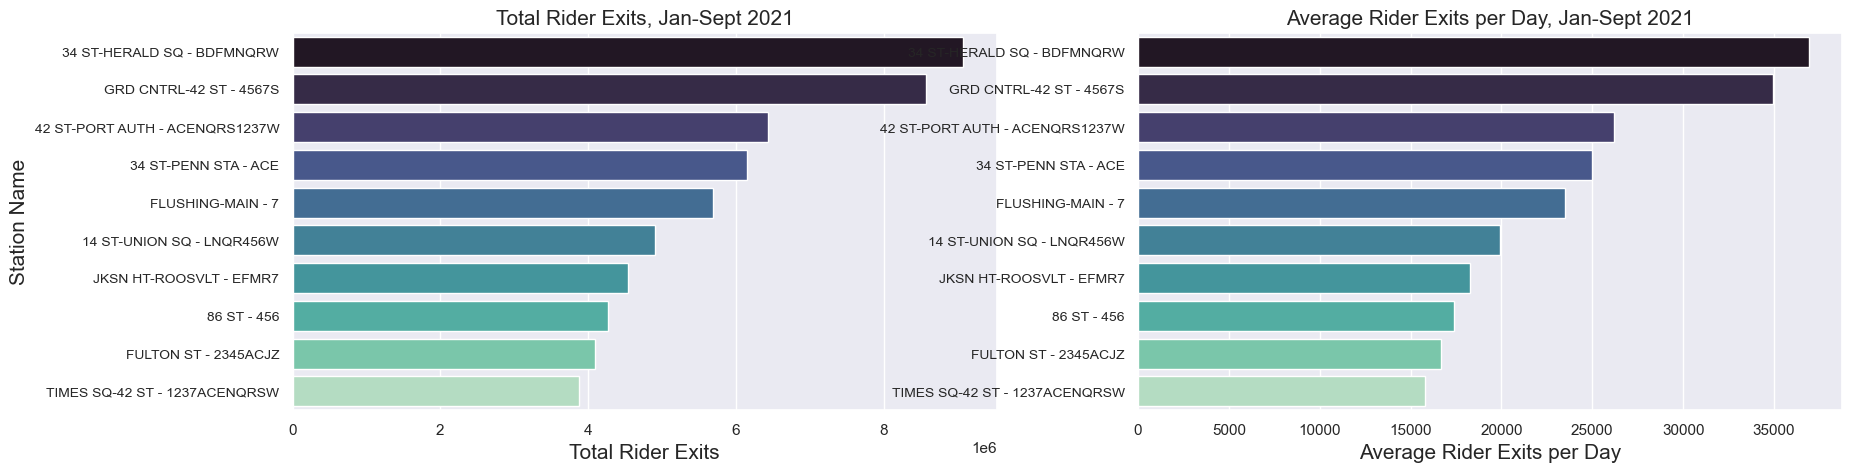

In [55]:
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2,figsize=(20,5))
chart = sns.barplot(y=highest_total_ten.station, x=highest_total_ten.station_exits_today, palette="mako", ax=axes[0])
chart.set_yticklabels(chart.get_ymajorticklabels(), fontsize = 10)

chart.set_ylabel('Station Name', fontsize=15)
chart.set_xlabel('Total Rider Exits', fontsize=15)
chart.set_title('Total Rider Exits, Jan-Sept 2021', fontsize=15)

chart2 = sns.barplot(y=highest_average_ten.station, x=highest_average_ten.station_exits_today, 
                     palette="mako", ax=axes[1])
chart2.set_yticklabels(chart2.get_ymajorticklabels(), fontsize = 10)
chart2.set_ylabel('')
chart2.set_xlabel('Average Rider Exits per Day', fontsize=15)
chart2.set_title('Average Rider Exits per Day, Jan-Sept 2021', fontsize=15)


In [56]:
lowest_average_ridership = all_df.groupby(['station'],as_index=False)[['station_exits_today']].mean().sort_values(by='station_exits_today',ascending=True)

#there are 379 total stations in the data

print(lowest_average_ridership)
lowest_average_ridership.describe()

                            station  station_exits_today
450               TOMPKINSVILLE - 1             0.008181
438                  ST. GEORGE - 1             4.260702
397               ORCHARD BEACH - 6             5.650019
421               RIT-MANHATTAN - R            42.695031
422               RIT-ROOSEVELT - R            50.972369
..                              ...                  ...
289               FLUSHING-MAIN - 7         23503.372650
93             34 ST-PENN STA - ACE         25004.179923
102  42 ST-PORT AUTH - ACENQRS1237W         26204.404765
312         GRD CNTRL-42 ST - 4567S         34932.745144
89       34 ST-HERALD SQ - BDFMNQRW         36918.866290

[478 rows x 2 columns]


station_exits_today
count           478.000000
mean           3752.294059
std            4260.954253
min               0.008181
25%            1286.151313
50%            2581.402785
75%            4494.042432
max           36918.866290

We can't put staff everywhere. In order to shrink our list of potential team locations, let's drop every station with ridership below the 50th percentile. 

In [57]:

# add average daily ridership as a column
all_df['station_avg_daily_ridership'] = all_df.groupby(['station']).station_exits_today.transform('mean')
all_df.sample(5)

high_ridership = all_df[all_df.station_avg_daily_ridership
                        > lowest_average_ridership.station_exits_today.quantile(.5)]

test = high_ridership.groupby(['station']).station_avg_daily_ridership.mean()
test.shape
#239 stations have average daily ridership above the 50th percentile. We'll work with high_ridership from now on 
#and ignore the other stations

(239,)

In [58]:
#filter our station_by_day dataframe down to just these 239 stations as well 
high_ridership_stations = high_ridership.station.unique()

#this will be our full-data dataframe, including period-specific data:
filtered_df = all_df[all_df.station.isin(high_ridership_stations)]
#this will be our dataframe that is grouped by station and less granular: 
station_by_day = station_by_day[station_by_day.station.isin(high_ridership_stations)]


### Activity over time

Text(0.5, 1.0, 'Ridership Over Time at 1st Ave Station')

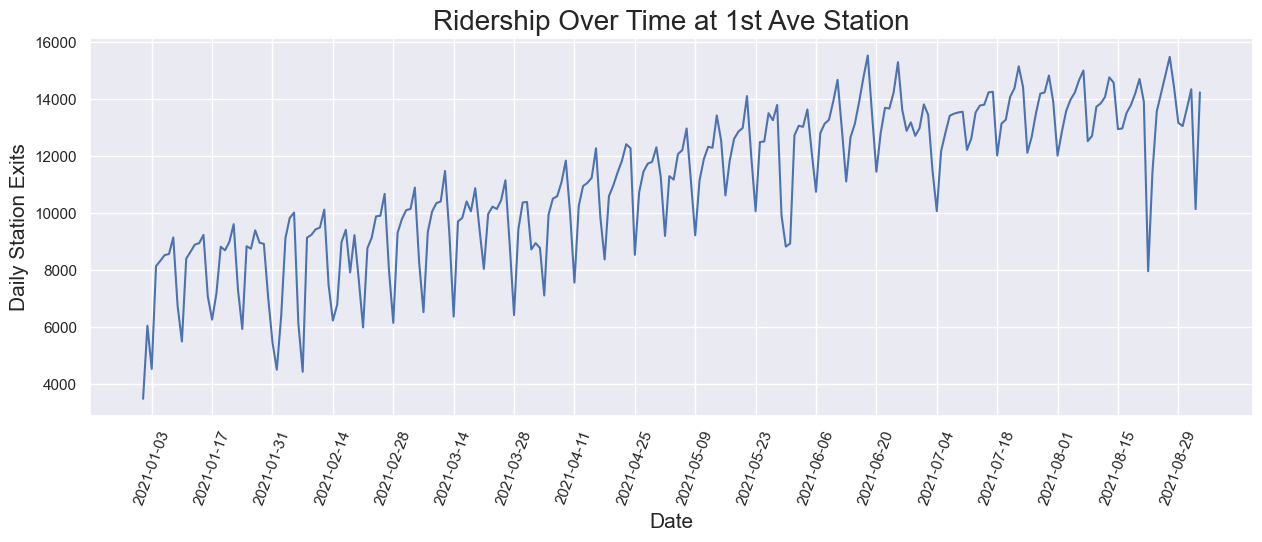

In [59]:
mask = station_by_day[(station_by_day.station=='1 AV - L')]
x1 = mask.date
y1 = mask.station_exits_today
xticks = list(mask.date.dt.date.unique())[2::14]

##this is all the data for this station, where the xticks fall on sundays

sns.set(rc = {'figure.figsize':(15,5)})
plot1 = sns.lineplot(x=x1,y=y1,legend=False)
plot1.set_xticks(xticks)   
plot1.set_xticklabels(labels =xticks, rotation=70)
plot1.set_xlabel('Date', fontsize=15)
plot1.set_ylabel('Daily Station Exits', fontsize=15)
plot1.set_title('Ridership Over Time at 1st Ave Station', fontsize=20)
# does every station follow this trend?

(-13348.1, 100000.0)

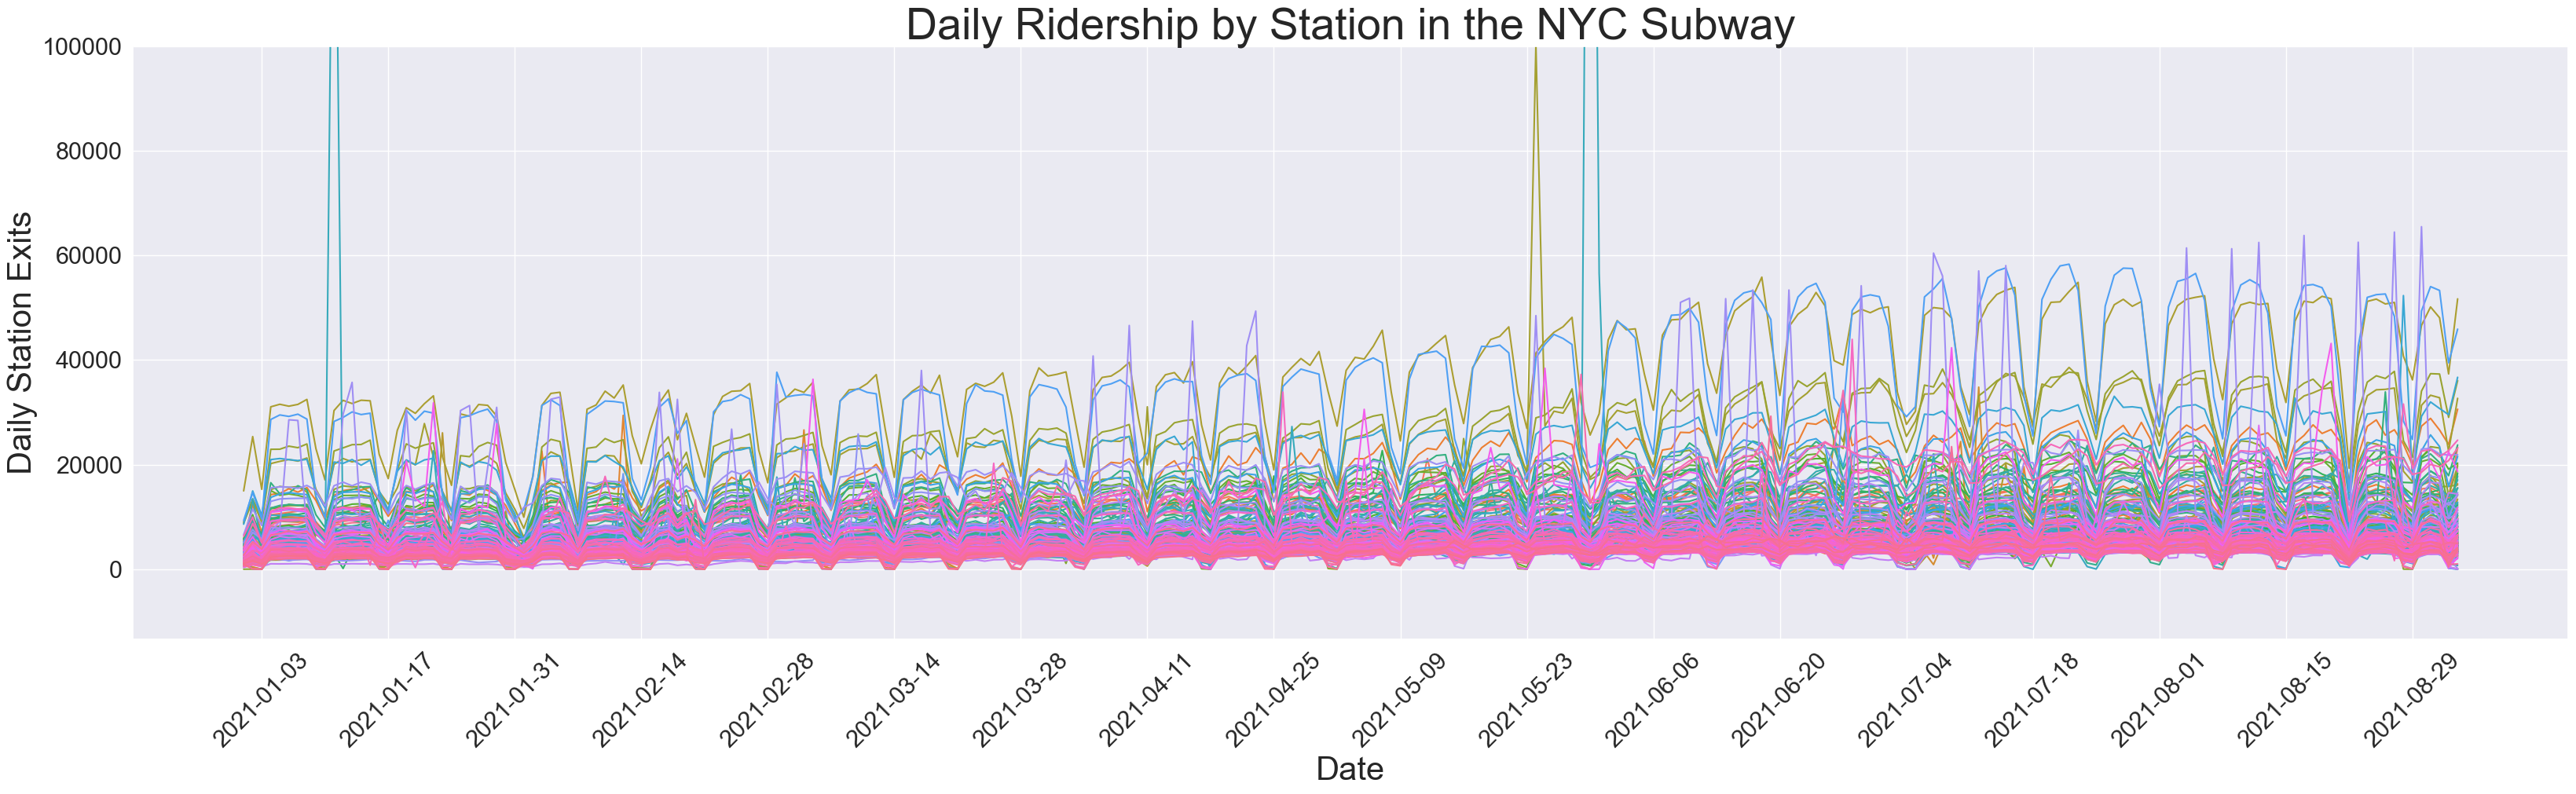

In [60]:

station_list = station_by_day.station.unique()

sns.set(rc={'figure.figsize':(40,10)})
sns.set(font_scale=2)
x = station_by_day.date
y = station_by_day.station_exits_today
station = station_by_day.station
xtick_data=station_by_day.date.dt.date.unique()

    
#set the xticks to start on sunday with 2 week intervals    
plot = sns.lineplot(x=x,y=y, hue=station, legend=False)
plot.set_xticks(xtick_data[2::14])   
plot.set_xticklabels(labels =xtick_data[2::14], rotation=45)
plot.set_xlabel('Date', fontsize=30)
plot.set_ylabel('Daily Station Exits', fontsize=30)
plot.set_title('Daily Ridership by Station in the NYC Subway', fontsize=40)
plt.ylim(top=100000)

    

It does look like on the whole, the NYC subway tends to follow a pattern of high weekday ridership with a lull on the weekends. 

That was fun, but here's an easier way to look at ridership by day of the week:

### Activity By Day of Week

In [61]:
total_by_day = station_by_day.groupby(['day_of_week'], as_index=False)[['station_exits_today']].sum()
average_per_day = station_by_day.groupby(['day_of_week'], as_index=False)[['station_exits_today']].mean()

In [62]:
import matplotlib.ticker as mticker 

days_xlabels= ['Mon','Tues','Weds','Thurs','Fri','Sat','Sun']
f, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5), dpi=1000)
total = sns.barplot(x=total_by_day.day_of_week, y=total_by_day.station_exits_today, ax=ax1, palette="mako")
total.set_xticklabels(days_xlabels, fontsize=15)
total.yaxis.set_major_locator(mticker.FixedLocator(total.get_yticks().tolist()))
total.set_yticklabels(total.get_yticks(), fontsize = 15)
total.set_ylabel('Total Rider Exits Jan-Sept 2021', fontsize=15)
total.set_xlabel('Day of the Week', fontsize=15)
total.set_title('Total Ridership by Day of the Week', fontsize=15)

average = sns.barplot(x=average_per_day.day_of_week, y=average_per_day.station_exits_today, ax=ax2, palette="mako")
average.set_xticklabels(days_xlabels, fontsize=15)
average.yaxis.set_major_locator(mticker.FixedLocator(average.get_yticks().tolist()))
average.set_yticklabels(average.get_yticks(), fontsize = 15)
average.set_ylabel('Average Rider Exits Jan-Sept 2021', fontsize=15)
average.set_xlabel('Day of the Week', fontsize=15)
average.set_title('Average Daily Ridership by Day of the Week', fontsize=15)



Text(0.5, 1.0, 'Average Daily Ridership by Day of the Week')

Since we're strategizing based on womens' interactions with schools and daycares, we'll focus on the weekdays. This looks great for ridership, will maximize school days, and is more respectful of the WTWY staff's time. 

In [63]:
weekdays = high_ridership[(high_ridership.day_of_week >=0) & (high_ridership.day_of_week <=4)]
print(weekdays.day_of_week.value_counts())
weekdays.head(5)

4    753620
0    736600
1    736382
3    734553
2    734478
Name: day_of_week, dtype: int64


ca  unit       scp   station line_name       date      time     desc  \
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L 2021-01-01  15:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L 2021-01-01  19:00:00  REGULAR   
5  H007  R248  00-00-00  1 AV - L         L 2021-01-01  23:00:00  REGULAR   

    entries     exits           date_time  entries_since_last_audit  \
1  15512489  17566802 2021-01-01 07:00:00                       2.0   
2  15512503  17566903 2021-01-01 11:00:00                      14.0   
3  15512538  17567059 2021-01-01 15:00:00                      35.0   
4  15512578  17567190 2021-01-01 19:00:00                      40.0   
5  15512611  17567283 2021-01-01 23:00:00                      33.0   

   exits_since_last_audit  real_entries_since_audit  real_exits_since_audit  \
1                    45.0                       2.0                    45.0   
2                   101.0                      14.0                   101.0   
3                   156.0                      35.0                   156.0   
4                   131.0                      40.0                   131.0   
5                    93.0                      33.0                    93.0   

   day_of_week  station_entries_today  station_exits_today  \
1            4                 2019.0               3492.0   
2            4                 2019.0               3492.0   
3            4                 2019.0               3492.0   
4            4                 2019.0               3492.0   
5            4                 2019.0               3492.0   

   station_avg_daily_ridership  
1                 11097.589011  
2                 11097.589011  
3                 11097.589011  
4                 11097.589011  
5                 11097.589011

# Adding in the Station Data

In [64]:
stations_orig = pd.read_csv('Stations.csv')
stations_orig=stations_orig.drop(columns=['ADA Notes', 'ADA', 'Structure','North Direction Label', 'South Direction Label'], axis=0)
stations_orig.rename(columns={'Station ID':'station_id', 'Complex ID':'complex_id', 'GTFS Stop ID':'stop_id', 
                'Division':'division', 'Line':'line','Stop Name':'stop_name','Borough':'borough',
                'Daytime Routes':'daytime_routes', 'GTFS Latitude':'latitude',
                'GTFS Longitude':'longitude'}, inplace=True)

In [65]:
stations = stations_orig.copy()
stations.stop_name = stations.stop_name.str.strip() + ' - ' + stations.daytime_routes.str.replace(' ', '')
stations.sort_values(by='stop_name').head()

station_id  complex_id stop_id division                line  \
118         119         119     L06      BMT            Canarsie   
309         309         309     119      IRT      Broadway - 7Av   
395         395         395     624      IRT        Lexington Av   
155         156         156     A18      IND  8th Av - Fulton St   
450         450         450     706      IRT            Flushing   

                   stop_name borough daytime_routes   latitude  longitude  
118                 1 Av - L       M              L  40.730953 -73.981628  
309               103 St - 1       M              1  40.799446 -73.968379  
395               103 St - 6       M              6  40.790600 -73.947478  
155              103 St - BC       M            B C  40.796092 -73.961454  
450  103 St-Corona Plaza - 7       Q              7  40.749865 -73.862700

In [66]:
stations.shape

(496, 10)

In [67]:
## Compare number of stations in the two datasets
filtered_df.station.nunique()

239

In [68]:
#matching station names in order to join tables
station_names_filtered_df = sorted(filtered_df.station.str.strip().unique())
stop_names_station_data = sorted(stations.stop_name.str.strip().str.upper())

station_dict = {}

for idx, station in enumerate(station_names_filtered_df):
    if station in stop_names_station_data:
        station_dict[station] = True
    else:
        station_dict[station] = False


In [69]:
station_dict

{'1 AV - L': True,
 '103 ST - 1': True,
 '103 ST - 6': True,
 '103 ST-CORONA - 7': False,
 '110 ST - 6': True,
 '111 ST - 7': True,
 '116 ST - 23': True,
 '116 ST - 6': True,
 '125 ST - 1': True,
 '125 ST - 23': True,
 '125 ST - 456': True,
 '125 ST - ACBD': False,
 '135 ST - 23': True,
 '137 ST CITY COL - 1': False,
 '14 ST - 123FLM': False,
 '14 ST - ACEL': False,
 '14 ST - FLM123': False,
 '14 ST-UNION SQ - 456LNQRW': False,
 '14 ST-UNION SQ - LNQR456W': False,
 '145 ST - 1': True,
 '145 ST - ABCD': False,
 '149/GRAND CONC - 245': False,
 '14TH STREET - 1': False,
 '157 ST - 1': True,
 '161/YANKEE STAD - BD4': False,
 '167 ST - 4': True,
 '168 ST - 1AC': False,
 '168 ST - AC1': False,
 '169 ST - F': True,
 '170 ST - 4': True,
 '174 ST - 25': True,
 '175 ST - A': True,
 '181 ST - A': True,
 '191 ST - 1': True,
 '2 AV - F': True,
 '21 ST-QNSBRIDGE - F': False,
 '23 ST - 1': True,
 '23 ST - 6': True,
 '23 ST - CE': True,
 '23 ST - FM': True,
 '23 ST - NRW': False,
 '28 ST - 1': True,
 

In [70]:
did_not_work = [k for k,v in station_dict.items() if v==False]

#these are the options left of names to match
stop_names_left = [x for x in stop_names_station_data if x not in station_dict.keys()]
print(len(stop_names_left))
len(did_not_work)


382


125

In [71]:
# for the first batch that worked automatically, replace them in the stations dataframe with the MTA dataset name
for index, row in stations.iterrows():
    stop_name = row.stop_name.strip().upper()
    if stop_name in station_dict:
        stations.at[index, 'match_stop_name'] = stop_name

stations.head(100)

station_id  complex_id stop_id division  \
0            1           1     R01      BMT   
1            2           2     R03      BMT   
2            3           3     R04      BMT   
3            4           4     R05      BMT   
4            5           5     R06      BMT   
5            6           6     R08      BMT   
6            7         613     R11      BMT   
7            8           8     R13      BMT   
8            9           9     R14      BMT   
9           10          10     R15      BMT   
10          11         611     R16      BMT   
11          12         607     R17      BMT   
12          13          13     R18      BMT   
13          14          14     R19      BMT   
14          15         602     R20      BMT   
15          16          16     R21      BMT   
16          17          17     R22      BMT   
17          18         623     R23      BMT   
18          19         623     Q01      BMT   
19          20          20     R24      BMT   
20          21         624     R25      BMT   
21          22          22     R26      BMT   
22          23         635     R27      BMT   
23          24         620     R28      BMT   
24          25         636     R29      BMT   
25          26          26     R30      BMT   
26          27         617     R31      BMT   
27          28          28     R32      BMT   
28          29         608     R33      BMT   
29          30          30     R34      BMT   
30          31          31     R35      BMT   
31          32          32     R36      BMT   
32          33          33     R39      BMT   
33          34          34     R40      BMT   
34          35          35     R41      BMT   
35          36          36     R42      BMT   
36          37          37     R43      BMT   
37          38          38     R44      BMT   
38          39          39     R45      BMT   
39          40         617     D24      BMT   
40          41          41     D25      BMT   
41          42          42     D26      BMT   
42          43          43     D27      BMT   
43          44          44     D28      BMT   
44          45          45     D29      BMT   
45          46          46     D30      BMT   
46          47          47     D31      BMT   
47          48          48     D32      BMT   
48          49          49     D33      BMT   
49          50          50     D34      BMT   
50          51          51     D35      BMT   
51          52          52     D37      BMT   
52          53          53     D38      BMT   
53          54          54     D39      BMT   
54          55          55     D40      BMT   
55          56          56     D41      BMT   
56          57          57     D42      BMT   
57          58          58     D43      BMT   
58          59          59     B12      BMT   
59          60          60     B13      BMT   
60          61          61     B14      BMT   
61          62          62     B15      BMT   
62          63         615     B16      BMT   
63          64          64     B17      BMT   
64          65          65     B18      BMT   
65          66          66     B19      BMT   
66          67          67     B20      BMT   
67          68          68     B21      BMT   
68          69          69     B22      BMT   
69          70          70     B23      BMT   
70          71          71     N02      BMT   
71          72          72     N03      BMT   
72          73         615     N04      BMT   
73          74          74     N05      BMT   
74          75          75     N06      BMT   
75          76          76     N07      BMT   
76          77          77     N08      BMT   
77          78          78     N09      BMT   
78          79          79     N10      BMT   
79          80          80     J12      BMT   
80          81          81     J13      BMT   
81          82          82     J14      BMT   
82          83          83     J15      BMT   
83          84          84     J16      BMT   
84       

In [72]:
print('All Station Names:', len(station_dict))
print('Did Not Successfully Match:', len(did_not_work))

All Station Names: 239
Did Not Successfully Match: 125


In [73]:
from fuzzywuzzy import process, fuzz

In [74]:
match_dict = {}
for station in did_not_work:
    highest = process.extractOne(station, stop_names_left)
    if highest[1] >= 90:
        match_dict[station] = highest[0]
        
print(match_dict)
len(match_dict)

{'103 ST-CORONA - 7': '103 ST-CORONA PLAZA - 7', '125 ST - ACBD': '125 ST - ABCD', '137 ST CITY COL - 1': '137 ST-CITY COLLEGE - 1', '14 ST - ACEL': '14 ST - ACE', '14 ST-UNION SQ - 456LNQRW': '14 ST-UNION SQ - NQRW', '14 ST-UNION SQ - LNQR456W': '14 ST-UNION SQ - NQRW', '145 ST - ABCD': '125 ST - ABCD', '168 ST - 1AC': '168 ST - AC', '168 ST - AC1': '168 ST - AC', '21 ST-QNSBRIDGE - F': '21 ST-QUEENSBRIDGE - F', '23 ST - NRW': '23 ST - RW', '28 ST - NRW': '28 ST - RW', '3 AV 138 ST - 6': '3 AV-138 ST - 6', '30 AV - NQW': '30 AV - NW', '34 ST-HERALD SQ - BDFMNQRW': '34 ST-HERALD SQ - BDFM', '34 ST-HUDSON YD - 7': '34 ST-HUDSON YARDS - 7', '34 ST-PENN STA - 123': '34 ST-PENN STATION - 123', '34 ST-PENN STA - ACE': '34 ST-PENN STATION - ACE', '36 AV - NQW': '36 AV - NW', '40 ST LOWERY ST - 7': '40 ST-LOWERY ST - 7', '42 ST-BRYANT PK - BDFM7': '42 ST-BRYANT PK - BDFM', '46 ST BLISS ST - 7': '46 ST-BLISS ST - 7', '49 ST - NQRW': '49 ST - NRW', '5 AV/59 ST - NQRW': '5 AV/59 ST - NWR', '59 S

58

In [75]:
# Now replace these names in the stations dataframe before dealing with the rest of the unmatched

for index, row in stations.iterrows():
    stop_name = row.stop_name.strip().upper()
    for station, stop in match_dict.items() :
        if stop_name == stop:
            stations.at[index, 'match_stop_name'] = station
        
stations.head(200).sort_values(by='stop_name')

station_id  complex_id stop_id division  \
118         119         119     L06      BMT   
155         156         156     A18      IND   
193         193         193     A63      IND   
81           82          82     J14      BMT   
194         194         194     A64      IND   
80           81          81     J13      BMT   
153         154         154     A16      IND   
79           80          80     J12      BMT   
152         153         153     A15      IND   
151         152         152     A14      IND   
165         166         618     A31      IND   
14           15         602     R20      BMT   
116         117         602     L03      BMT   
149         151         151     A12      IND   
150         151         151     D13      IND   
148         150         150     A11      IND   
147         149         149     A10      IND   
146         148         605     A09      IND   
145         147         147     A07      IND   
65           66          66     B19      BMT   
73           74          74     N05      BMT   
144         146         146     A06      IND   
143         145         145     A05      IND   
66           67          67     B20      BMT   
74           75          75     N06      BMT   
164         165         165     A30      IND   
13           14          14     R19      BMT   
68           69          69     B22      BMT   
30           31          31     R35      BMT   
12           13          13     R18      BMT   
117         118         118     L05      BMT   
2             3           3     R04      BMT   
11           12         607     R17      BMT   
163         164         164     A28      IND   
4             5           5     R06      BMT   
31           32          32     R36      BMT   
5             6           6     R08      BMT   
28           29         608     R33      BMT   
162         163         611     A27      IND   
32           33          33     R39      BMT   
9            10          10     R15      BMT   
7             8           8     R13      BMT   
161         162         162     A25      IND   
60           61          61     B14      BMT   
33           34          34     R40      BMT   
61           62          62     B15      BMT   
8             9           9     R14      BMT   
34           35          35     R41      BMT   
160         161         614     A24      IND   
115         116         601     L02      BMT   
62           63         615     B16      BMT   
40           41          41     D25      BMT   
63           64          64     B17      BMT   
159         160         160     A22      IND   
84           85          85     J17      BMT   
36           37          37     R43      BMT   
64           65          65     B18      BMT   
114         115         618     L01      BMT   
70           71          71     N02      BMT   
15           16          16     R21      BMT   
190         190         190     A59      IND   
158         159         159     A21      IND   
83           84          84     J16      BMT   
157         158         158     A20      IND   
78           79          79     N10      BMT   
37           38          38     R44      BMT   
191         191         191     A60      IND   
58           59          59     B12      BMT   
156         157         157     A19      IND   
90           91          91     J24      BMT   
196         196         196     H01      IND   
197         197         197     H02      IND   
1             2           2     R03      BMT   
0             1           1     R01      BMT   
132         133         133     L24      BMT   
39           40         617     D24      BMT   
26           27         617     R31      BMT   
47           48          48     D32      BMT   
48           49          49     D33      BMT   
49           50          50     D34      BMT   
77           78          78     N09      BMT   
51           52          52     D37      BMT   
69           70      

In [76]:
#how many unmatched names are left?
for key in match_dict.keys():
    station_dict[key] = True 
    
still_unmatched = [k for k,v in station_dict.items() if v==False ]
len(still_unmatched)

67

For these last 67, we may just have to do them manually. Let's take a look:

In [77]:
print(still_unmatched)

['14 ST - 123FLM', '14 ST - FLM123', '149/GRAND CONC - 245', '14TH STREET - 1', '161/YANKEE STAD - BD4', '34 ST-PENN STA - 123ACE', '42 ST-PORT AUTH - ACENGRS1237W', '42 ST-PORT AUTH - ACENQRS1237W', '47-50 STS ROCK - BDFM', '4AV-9 ST - DFGMNR', '5 AVE - 7BDFM', '59 ST - 456NQRW', '59 ST - NQR456W', '59 ST COLUMBUS - 1ABCD', '59 ST COLUMBUS - ABCD1', '68ST-HUNTER CO - 6', '72 ST-2 AVE - Q', '8 AV - ACEL', '81 ST-MUSEUM - BC', '86 ST-2 AVE - Q', '96 ST-2 AVE - Q', 'ASTORIA DITMARS - NQW', 'ATL AV-BARCLAY - 2345BDNQR', 'ATL AV-BARCLAY - BDNQR2345', "B'WAY-LAFAYETTE - BDFQ6", 'BEDFORD-NOSTRAN - G', 'BROADWAY JCT - ACJLZ', 'BROOKLYN BRIDGE - 456JZ', 'CANAL ST - JNQRZ6W', 'CATHEDRAL PKWY - 1', 'CENTRAL PK N110 - 23', 'CHRISTOPHER ST - 1', 'CITY / BUS - 1', 'CONEY IS-STILLW - DFNQ', 'DELANCEY/ESSEX - FJMZ', 'EXCHANGE PLACE - 1', 'FLATBUSH AV-B.C - 25', 'FRANKLIN AV - 2345S', 'FULTON ST - 2345ACJZ', 'FULTON ST - ACJZ2345', 'GRD CNTRL-42 ST - 4567S', 'GROVE STREET - 1', 'HARRISON - 1', 'HOYT-S

After some research, we were able to match 15 of the final 35 names. The final 20 names, which couldn't be matched (or even found in some cases) will be dropped for lack of data. 

In [78]:
final_unmatched_dict = {'14TH STREET - 123FLM': '14 St - FM',
                        '14 ST - FLM123': '14 St - FM',
                        '149/GRAND CONC - 245': '149 St-Grand Concourse - 25',
                        '161/YANKEE STAD - BD4': '161 St-Yankee Stadium - BD',
                        '34 ST-PENN STA - 123ACE': '34 St-Penn Station - 123',
                        '42 ST-PORT AUTH - ACENGRS1237W': '42 St-Port Authority Bus Terminal - ACE',
                        '47-50 STS ROCK - BDFM': '47-50 Sts-Rockefeller Ctr - BDFM',
                        '4AV-9 ST - DFGMNR': '4 Av-9 St - R',
                        '5 AVE - 7BDFM': '5 Av - 7',  
                        '59 ST - 456NQRW': '59 St - 456',
                        '59 ST - NQR456W': '59 St - 456',
                        '59 ST COLUMBUS - 1ABCD': '59 St-Columbus Circle - ABCD',
                        '59 ST COLUMBUS - ABCD1': '59 St-Columbus Circle - ABCD',
                        '68ST-HUNTER CO - 6': '68 St-Hunter College - 6',
                        '72 ST-2 AVE - Q':'72 St - Q', 
                        '8 AV - ACEL' : '8 Av - L',
                        '81 ST-MUSEUM - BC': '81 St-Museum of Natural History - BC',
                        '86 ST-2 AVE - Q':'86 St - Q', 
                        '96 ST-2 AVE - Q':'96 St - Q', 
                        'ASTORIA DITMARS - NQW': 'Astoria-Ditmars Blvd - NW',   
                        'ATL AV-BARCLAY - 2345BDNQR':'Atlantic Av-Barclays Ctr - 2345',
                        'ATL AV-BARCLAY - BDNQR2345': 'Atlantic Av-Barclays Ctr - 2345',
                        "B'WAY-LAFAYETTE - BDFQ6":'Broadway-Lafayette St - BDFM',
                        'BEDFORD-NOSTRAN - G':'Bedford-Nostrand Avs - G',
                        'BROADWAY JCT - ACJLZ':'Broadway Junction - AC', 
                        'BROOKLYN BRIDGE - 456JZ': 'Brooklyn Bridge-City Hall - 456',
                        'CANAL ST - JNQRZ6W': 'Canal St - NQ',
                        'CATHEDRAL PKWY - 1': 'Cathedral Pkwy (110 St) - 1',
                        'CENTRAL PK N110 - 23': 'Central Park North (110 St) - 23',
                        'CHRISTOPHER ST - 1': 'Christopher St-Sheridan Sq - 1',
                        'CONEY IS-STILLW - DFNQ': 'Coney Island-Stillwell Av - DFNQ',
                        'DELANCEY/ESSEX - FJMZ': 'Delancey St-Essex St - JMZ',
                        'FLATBUSH AV-B.C - 25': 'Flatbush Av-Brooklyn College - 25',
                        'FRANKLIN AV - 2345S': 'Franklin Avenue-Medgar Evers College - 2345',
                        'FULTON ST - 2345ACJZ': 'Fulton St - AC',
                        'FULTON ST - ACJZ2345': 'Fulton St - AC',
                        'GRD CNTRL-42 ST - 4567S': 'Grand Central-42 St - 456',
                        'HOYT-SCHER - ACG':'Hoyt-Schermerhorn Sts - ACG',
                        'JAMAICA CENTER - EJZ': 'Jamaica Center-Parsons/Archer - EJZ',
                        'JFK JAMAICA CT1 - E': 'Jamaica-Van Wyck - E',
                        'JKSN HT-ROOSVLT - EFMR7': 'Jackson Hts-Roosevelt Av - EFMR',
                        'KEW GARDENS - EF': 'Kew Gardens-Union Tpke - EF',
                        'MORISN AV/SNDVW - 6': 'Morrison Av-Soundview - 6',
                        'MYRTLE-WYCKOFF - LM': 'Myrtle-Wyckoff Avs - L',
                        'OZONE PK LEFFRT - A':'Ozone Park-Lefferts Blvd - A',
                        'SUTPHIN-ARCHER - EJZ': 'Sutphin Blvd-Archer Av-JFK Airport - EJZ',
                        'SUTTER AV-RUTLD - 3': 'Sutter Av-Rutland Rd - 3',
                        'THIRTY ST - 1':'30 Av - NW',  
                        'THIRTY THIRD ST - 1': '33 St - 6',
                        'TIMES SQ-42 ST - 1237ACENQRS': 'Times Sq-42 St - 123',
                        'TIMES SQ-42 ST - 1237ACENQRSW': 'Times Sq-42 St - 123',
                        'TIMES SQ-42 ST - ACENQRS1237W': 'Times Sq-42 St - 123',
                        'WEST FARMS SQ - 25': 'West Farms Sq-E Tremont Av - 25',
                        'WESTCHESTER SQ - 6': 'Westchester Sq-E Tremont Av - 6',
                        'WHITEHALL S-FRY - R1W':'Whitehall St-South Ferry - RW',
                        'WORLD TRADE CTR - ACE23': 'World Trade Center - E'}

In [79]:
# Replace those final stations:

for index, row in stations.iterrows():
    stop_name = row.stop_name.strip()
    for station, stop in final_unmatched_dict.items() :
        if stop_name == stop:
            stations.at[index, 'match_stop_name'] = station

print(stations.info())
stations.head(200).sort_values(by='stop_name')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   station_id       496 non-null    int64  
 1   complex_id       496 non-null    int64  
 2   stop_id          496 non-null    object 
 3   division         496 non-null    object 
 4   line             496 non-null    object 
 5   stop_name        496 non-null    object 
 6   borough          496 non-null    object 
 7   daytime_routes   496 non-null    object 
 8   latitude         496 non-null    float64
 9   longitude        496 non-null    float64
 10  match_stop_name  215 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 42.8+ KB
None


station_id  complex_id stop_id division  \
118         119         119     L06      BMT   
155         156         156     A18      IND   
193         193         193     A63      IND   
81           82          82     J14      BMT   
194         194         194     A64      IND   
80           81          81     J13      BMT   
153         154         154     A16      IND   
79           80          80     J12      BMT   
152         153         153     A15      IND   
151         152         152     A14      IND   
165         166         618     A31      IND   
14           15         602     R20      BMT   
116         117         602     L03      BMT   
149         151         151     A12      IND   
150         151         151     D13      IND   
148         150         150     A11      IND   
147         149         149     A10      IND   
146         148         605     A09      IND   
145         147         147     A07      IND   
65           66          66     B19      BMT   
73           74          74     N05      BMT   
144         146         146     A06      IND   
143         145         145     A05      IND   
66           67          67     B20      BMT   
74           75          75     N06      BMT   
164         165         165     A30      IND   
13           14          14     R19      BMT   
68           69          69     B22      BMT   
30           31          31     R35      BMT   
12           13          13     R18      BMT   
117         118         118     L05      BMT   
2             3           3     R04      BMT   
11           12         607     R17      BMT   
163         164         164     A28      IND   
4             5           5     R06      BMT   
31           32          32     R36      BMT   
5             6           6     R08      BMT   
28           29         608     R33      BMT   
162         163         611     A27      IND   
32           33          33     R39      BMT   
9            10          10     R15      BMT   
7             8           8     R13      BMT   
161         162         162     A25      IND   
60           61          61     B14      BMT   
33           34          34     R40      BMT   
61           62          62     B15      BMT   
8             9           9     R14      BMT   
34           35          35     R41      BMT   
160         161         614     A24      IND   
115         116         601     L02      BMT   
62           63         615     B16      BMT   
40           41          41     D25      BMT   
63           64          64     B17      BMT   
159         160         160     A22      IND   
84           85          85     J17      BMT   
36           37          37     R43      BMT   
64           65          65     B18      BMT   
114         115         618     L01      BMT   
70           71          71     N02      BMT   
15           16          16     R21      BMT   
190         190         190     A59      IND   
158         159         159     A21      IND   
83           84          84     J16      BMT   
157         158         158     A20      IND   
78           79          79     N10      BMT   
37           38          38     R44      BMT   
191         191         191     A60      IND   
58           59          59     B12      BMT   
156         157         157     A19      IND   
90           91          91     J24      BMT   
196         196         196     H01      IND   
197         197         197     H02      IND   
1             2           2     R03      BMT   
0             1           1     R01      BMT   
132         133         133     L24      BMT   
39           40         617     D24      BMT   
26           27         617     R31      BMT   
47           48          48     D32      BMT   
48           49          49     D33      BMT   
49           50          50     D34      BMT   
77           78          78     N09      BMT   
51           52          52     D37      BMT   
69           70      

In [80]:
    
final_stations = stations.dropna(axis=0, subset=['match_stop_name'])
final_stations.head(200).sort_values(by='match_stop_name')

station_id  complex_id stop_id division  \
118         119         119     L06      BMT   
309         309         309     119      IRT   
395         395         395     624      IRT   
394         394         394     623      IRT   
449         449         449     705      IRT   
440         440         440     226      IRT   
393         393         393     622      IRT   
306         306         306     116      IRT   
439         439         439     225      IRT   
392         392         392     621      IRT   
438         438         438     224      IRT   
305         305         305     115      IRT   
165         166         618     A31      IND   
229         229         601     D19      IND   
14           15         602     R20      BMT   
304         304         304     114      IRT   
152         153         153     A15      IND   
435         435         603     222      IRT   
303         303         303     113      IRT   
219         219         604     D11      IND   
388         388         388     413      IRT   
146         148         605     A09      IND   
255         255         255     F02      IND   
387         387         387     412      IRT   
428         428         428     215      IRT   
145         147         147     A07      IND   
144         146         146     A06      IND   
300         300         300     110      IRT   
232         232         232     F14      IND   
221         221         221     B04      IND   
320         320         320     130      IRT   
405         405         405     634      IRT   
164         165         165     A30      IND   
228         228         228     D18      IND   
13           14          14     R19      BMT   
319         319         319     129      IRT   
404         404         404     633      IRT   
12           13          13     R18      BMT   
117         118         118     L05      BMT   
377         377         377     619      IRT   
434         434         434     221      IRT   
227         227         607     D17      IND   
318         318         318     128      IRT   
163         164         164     A28      IND   
4             5           5     R06      BMT   
31           32          32     R36      BMT   
226         226         609     D16      IND   
162         163         611     A27      IND   
270         270         270     G18      IND   
225         225         225     D15      IND   
9            10          10     R15      BMT   
28           29         608     R33      BMT   
276         276         276     F12      IND   
7             8           8     R13      BMT   
316         316         316     126      IRT   
161         162         162     A25      IND   
401         401         612     630      IRT   
33           34          34     R40      BMT   
224         224         224     B10      IND   
8             9           9     R14      BMT   
400         400         613     629      IRT   
34           35          35     R41      BMT   
160         161         614     A24      IND   
263         263         263     G10      IND   
314         314         314     124      IRT   
399         399         399     628      IRT   
277         277         277     D14      IND   
40           41          41     D25      BMT   
313         313         313     123      IRT   
159         160         160     A22      IND   
398         398         398     627      IRT   
312         312         312     122      IRT   
114         115         618     L01      BMT   
70           71          71     N02      BMT   
15           16          16     R21      BMT   
158         159         159     A21      IND   
311         311         311     121      IRT   
397         397         397     626      IRT   
157         158         158     A20      IND   
37           38          38     R44      BMT   
310         310         310     120      IRT   
396         396         396     625      IRT   
156         157      

In [81]:
final_stations.shape

(215, 11)

## Joining the Station Location Data with MTA Turnstiles 

In [82]:
merged_df = pd.merge(filtered_df,final_stations,left_on='station',right_on='match_stop_name')
merged_station_by_day = pd.merge(station_by_day,final_stations,left_on='station',right_on='match_stop_name')

In [83]:
pd.options.display.max_columns = 100
merged_df.head()

ca  unit       scp   station line_name       date      time     desc  \
0  H007  R248  00-00-00  1 AV - L         L 2021-01-01  07:00:00  REGULAR   
1  H007  R248  00-00-00  1 AV - L         L 2021-01-01  11:00:00  REGULAR   
2  H007  R248  00-00-00  1 AV - L         L 2021-01-01  15:00:00  REGULAR   
3  H007  R248  00-00-00  1 AV - L         L 2021-01-01  19:00:00  REGULAR   
4  H007  R248  00-00-00  1 AV - L         L 2021-01-01  23:00:00  REGULAR   

    entries     exits           date_time  entries_since_last_audit  \
0  15512489  17566802 2021-01-01 07:00:00                       2.0   
1  15512503  17566903 2021-01-01 11:00:00                      14.0   
2  15512538  17567059 2021-01-01 15:00:00                      35.0   
3  15512578  17567190 2021-01-01 19:00:00                      40.0   
4  15512611  17567283 2021-01-01 23:00:00                      33.0   

   exits_since_last_audit  real_entries_since_audit  real_exits_since_audit  \
0                    45.0                       2.0                    45.0   
1                   101.0                      14.0                   101.0   
2                   156.0                      35.0                   156.0   
3                   131.0                      40.0                   131.0   
4                    93.0                      33.0                    93.0   

   day_of_week  station_entries_today  station_exits_today  \
0            4                 2019.0               3492.0   
1            4                 2019.0               3492.0   
2            4                 2019.0               3492.0   
3            4                 2019.0               3492.0   
4            4                 2019.0               3492.0   

   station_avg_daily_ridership  station_id  complex_id stop_id division  \
0                 11097.589011         119         119     L06      BMT   
1                 11097.589011         119         119     L06      BMT   
2                 11097.589011         119         119     L06      BMT   
3                 11097.589011         119         119     L06      BMT   
4                 11097.589011         119         119     L06      BMT   

       line stop_name borough daytime_routes   latitude  longitude  \
0  Canarsie  1 Av - L       M              L  40.730953 -73.981628   
1  Canarsie  1 Av - L       M              L  40.730953 -73.981628   
2  Canarsie  1 Av - L       M              L  40.730953 -73.981628   
3  Canarsie  1 Av - L       M              L  40.730953 -73.981628   
4  Canarsie  1 Av - L       M              L  40.730953 -73.981628   

  match_stop_name  
0        1 AV - L  
1        1 AV - L  
2        1 AV - L  
3        1 AV - L  
4        1 AV - L

In [84]:
merged_station_by_day.sample(100)

station       date  day_of_week  \
28959         CATHEDRAL PKWY - 1 2021-07-06            1   
6278                 174 ST - 25 2021-05-11            1   
17738         68ST-HUNTER CO - 6 2021-02-02            1   
49651               UNION ST - R 2021-08-06            4   
43475           NEVINS ST - 2345 2021-07-09            4   
9545                 28 ST - NRW 2021-07-20            1   
52686                YORK ST - F 2021-02-25            3   
28499         CANAL ST - JNQRZ6W 2021-08-07            5   
29324          CHAMBERS ST - 123 2021-03-01            0   
39841          JUNCTION BLVD - 7 2021-09-03            4   
3967                  145 ST - 1 2021-02-01            0   
8956                   28 ST - 1 2021-04-14            2   
23835               ASTOR PL - 6 2021-08-17            1   
44858        OZONE PK LEFFRT - A 2021-04-07            2   
23968         ASTORIA BLVD - NQW 2021-04-26            0   
17241       63 DR-REGO PARK - MR 2021-01-28            3   
9511                 28 ST - NRW 2021-06-16            2   
44334         NORWOOD 205 ST - D 2021-03-06            5   
24624    B'WAY-LAFAYETTE - BDFQ6 2021-02-03            2   
27651    BROOKLYN BRIDGE - 456JZ 2021-04-19            0   
31302             COURT SQ - EMG 2021-03-11            3   
41739       METROPOLITAN AV - GL 2021-06-25            4   
18580                  7 AV - BQ 2021-05-17            0   
32065          DEKALB AV - BDNQR 2021-04-05            0   
28621         CASTLE HILL AV - 6 2021-04-05            0   
41763       METROPOLITAN AV - GL 2021-07-19            0   
2613                125 ST - 456 2021-06-03            3   
6015                  170 ST - 4 2021-04-24            5   
45387           PARSONS BLVD - F 2021-05-14            4   
50027         VERNON-JACKSON - 7 2021-04-12            0   
30215         CHRISTOPHER ST - 1 2021-08-01            6   
20621             8 ST-NYU - NRW 2021-08-01            6   
18402                 7 AV - BDE 2021-07-24            5   
13818            5 AV/53 ST - EM 2021-02-15            0   
32124          DEKALB AV - BDNQR 2021-06-03            3   
7074                  191 ST - 1 2021-07-09            4   
13597          4AV-9 ST - DFGMNR 2021-03-12            4   
4357               145 ST - ABCD 2021-06-25            4   
47633              SPRING ST - 6 2021-06-15            1   
11931        40 ST LOWERY ST - 7 2021-05-07            4   
41729       METROPOLITAN AV - GL 2021-06-15            1   
5036       161/YANKEE STAD - BD4 2021-04-27            1   
5834                  169 ST - F 2021-06-28            0   
46626        ROOSEVELT ISLND - F 2021-05-23            6   
13432               49 ST - NQRW 2021-06-01            1   
36105               GRAND ST - L 2021-07-19            0   
52450          WTC-CORTLANDT - 1 2021-03-07            6   
17331       63 DR-REGO PARK - MR 2021-04-28            2   
36218         GRAND-NEWTOWN - MR 2021-03-08            0   
11814        40 ST LOWERY ST - 7 2021-01-10            6   
486                   103 ST - 1 2021-08-29            6   
6780                  181 ST - A 2021-05-21            4   
35936               GRAND ST - L 2021-01-31            6   
50433          WAKEFIELD/241 - 2 2021-01-16            5   
39339        JFK JAMAICA CT1 - E 2021-08-24            1   
50887               WALL ST - 23 2021-08-12            3   
5679                  169 ST - F 2021-01-24            6   
45061            PARKCHESTER - 6 2021-02-23            1   
9432                 28 ST - NRW 2021-03-29            0   
11166       34 ST-PENN STA - ACE 2021-04-10            5   
34072            FORDHAM RD - BD 2021-05-15            5   
34185     FOREST HILLS 71 - EFMR 2021-01-02            5   
39491    JKSN HT-ROOSVLT - EFMR7 2021-05-22            5   
37238               HIGH ST - AC 2021-04-13            1   
1278                  111 ST - 7 2021-02-18            3   
3053         137 ST CITY COL - 1 2021-04-12            0   
20923

## Adding in School & Daycare Data

In [85]:
import geopy

daycares = pd.read_csv('Child_Care_Regulated_Programs.csv')
schools = pd.read_csv('2019_-_2020_School_Locations.csv')

In [86]:
pd.options.display.max_columns = 100


daycares.dropna(axis=0, subset=['Latitude','Longitude'], inplace=True)
daycares.drop(axis=1, labels=['Program Profile','Total Capacity','School Age Capacity',
                               'Preschool Capacity', 'Toddler Capacity','Infant Capacity',
                               'Capacity Description', 'Provider Name','Phone Extension',
                               'Phone Number','Phone Number Omitted','Apartment', 'Floor',
                               'Additional Address', 'Address Omitted', 'License Expiration Date',
                               'License Issue Date', 'Facility Opened Date', 'County'], inplace=True)


In [87]:
daycares = daycares[(daycares['Region Code'] == 'NYCDOH') & 
                   (daycares['Facility Status'] != 'PENDING REVOCATION') &
                   (daycares['Facility Status'] != 'PENDING REVOCATION & DENIAL') &
                   (daycares['Facility Status'] != 'PENDING DENIAL') &
                   (daycares['Facility Status'] != 'SUSPENDED')]

daycares.drop_duplicates(subset=['Facility Name'],inplace=True)
print(daycares.shape)
daycares.head()

(7075, 14)


Facility ID Program Type Region Code Facility Status  \
11       180842         SACC      NYCDOH    Registration   
13       221580          FDC      NYCDOH    Registration   
14       227440         SACC      NYCDOH    Registration   
19       274852         GFDC      NYCDOH         License   
20       280657         SACC      NYCDOH    Registration   

                                        Facility Name Street Number  \
11               Queens Community House, Inc. @ PS 86         87-41   
13                                   Calderon, Benita          1982   
14  Sesame Flyers International, Inc Bildersee Bea...           956   
19                                     Fernandez, Luz          1552   
20                                Big Apple Institute          2937   

              Street Name      City State  Zip Code School District Name  \
11           Parsons Blvd   Jamaica    NY     11432            Queens 28   
13          WALTON AVENUE     BRONX    NY     10453              Bronx 9   
14            E. 82nd St.  Brooklyn    NY     11236          Brooklyn 18   
19  Saint Lawrence Avenue     Bronx    NY     10460             Bronx 11   
20                86th St  Brooklyn    NY     11223          Brooklyn 21   

     Latitude  Longitude                  Georeference  
11  40.709095 -73.803887  POINT (-73.803887 40.709095)  
13  40.851936 -73.907683  POINT (-73.907683 40.851936)  
14  40.635440 -73.910885   POINT (-73.910885 40.63544)  
19  40.839556 -73.868169  POINT (-73.868169 40.839556)  
20  40.590642 -73.974855  POINT (-73.974855 40.590642)

In [88]:
print(schools.shape)
schools.head()

(2190, 41)


fiscal_year system_code location_code                 location_name  \
0         2020      15K001          K001           P.S. 001 The Bergen   
1         2020      17K002          K002  Parkside Preparatory Academy   
2         2020      13K003          K003  P.S. 003 The Bedford Village   
3         2020      75K004          K004                     P.S. K004   
4         2020      16K005          K005    P.S. 005 Dr. Ronald McNair   

           BEDS Managed_by_name location_type_description  \
0  331500010001             DOE          General Academic   
1  331700010002             DOE          General Academic   
2  331300010003             DOE          General Academic   
3  307500013004             DOE         Special Education   
4  331600010005             DOE          General Academic   

     Location_Category_Description              Grades_text  \
0                       Elementary  PK,0K,01,02,03,04,05,SE   
1  Junior High-Intermediate-Middle              06,07,08,SE   
2                       Elementary  PK,0K,01,02,03,04,05,SE   
3                       Elementary  PK,0K,01,02,03,04,05,SE   
4                       Elementary  PK,0K,01,02,03,04,05,SE   

               Grades_final_text                open_date Status_descriptions  \
0           PK,0K,01,02,03,04,05  1965-07-01T00:00:00.000                Open   
1                       06,07,08  1994-07-01T00:00:00.000                Open   
2           PK,0K,01,02,03,04,05  1950-07-01T00:00:00.000                Open   
3  PK,0K,01,02,03,04,05,06,07,SE  1999-07-01T00:00:00.000                Open   
4           PK,0K,01,02,03,04,05  1966-07-01T00:00:00.000                Open   

  Primary_building_code primary_address_line_1 State_code  X_COORDINATE  \
0                  K001          309 47 STREET         NY      981081.0   
1                  K002    655 PARKSIDE AVENUE         NY      997686.0   
2                  K003    50 JEFFERSON AVENUE         NY      996670.0   
3                  K273      923 JEROME STREET         NY     1017745.0   
4                  K005     820 HANCOCK STREET         NY     1005891.0   

   Y_COORDINATE  LONGITUDE   LATITUDE  Community_district  Council-district  \
0      175710.0 -74.011420  40.648959               307.0              38.0   
1      178433.0 -73.951575  40.656423               309.0              40.0   
2      187864.0 -73.955219  40.682311               303.0              36.0   
3      179209.0 -73.879276  40.658500               305.0              42.0   
4      188938.0 -73.921970  40.685241               303.0              41.0   

   Census_tract  Borough_block_lot   NTA                           NTA_Name  \
0        8000.0       3.007550e+09  BK32                   Sunset Park West   
1       80200.0       3.050500e+09  BK60  Prospect Lefferts Gardens-Wingate   
2       22700.0       3.019980e+09  BK69                       Clinton Hill   
3      107800.0       3.044010e+09  BK82                      East New York   
4       37700.0       3.014900e+09  BK35                 Stuyvesant Heights   

      Principal_Name Principal_title Principal_phone_number    fax_number  \
0       Arlene Ramos       Principal           718-567-7661  718-567-9771   
1   ADRIENNE SPENCER       Principal           718-462-6992  718-284-7717   
2   KRISTINA BEECHER       Principal           718-622-2960  718-623-3193   
3  Rebecca Schropfer       Principal           929-275-3937  718-927-3554   
4         LENA GATES       Principal           718-218-2444  718-218-2445   

   Geographical_District_code  Administrative_District_Code  \
0                          15                            15   
1                          17                            17   
2                          13                            13   
3                          19                            75   
4                          16                            16   

   Administrative_District_Name community_school_sup_name  \
0  COMMUNITY SCHOOL D

In [89]:
schools.drop(axis=1, labels=['Managed_by_name','fiscal_year','system_code','BEDS','open_date',
                            'Primary_building_code', 'X_COORDINATE','Y_COORDINATE', 'Community_district',
                            'Council-district','Census_tract','Borough_block_lot', 'NTA', 'NTA_Name',
                            'Principal_Name','Principal_title','Principal_phone_number','fax_number',
                            'Geographical_District_code', 'Administrative_District_Code', 'Administrative_District_Name',
                            'community_school_sup_name', 'Tier_3_Support_Location_Name','Tier_3_Support_Leader_Name',
                            'Tier_2_Support_Location_Name', 'HighSchool_Network_Location_Code', 'HighSchool_Network_Name',
                            'HighSchool_Network_Superintendent','Community_district 1', 'Police_precinct'], inplace=True)

schools.drop_duplicates(subset = ['location_name'],inplace=True)

In [90]:
schools.head()

location_code                 location_name location_type_description  \
0          K001           P.S. 001 The Bergen          General Academic   
1          K002  Parkside Preparatory Academy          General Academic   
2          K003  P.S. 003 The Bedford Village          General Academic   
3          K004                     P.S. K004         Special Education   
4          K005    P.S. 005 Dr. Ronald McNair          General Academic   

     Location_Category_Description              Grades_text  \
0                       Elementary  PK,0K,01,02,03,04,05,SE   
1  Junior High-Intermediate-Middle              06,07,08,SE   
2                       Elementary  PK,0K,01,02,03,04,05,SE   
3                       Elementary  PK,0K,01,02,03,04,05,SE   
4                       Elementary  PK,0K,01,02,03,04,05,SE   

               Grades_final_text Status_descriptions primary_address_line_1  \
0           PK,0K,01,02,03,04,05                Open          309 47 STREET   
1                       06,07,08                Open    655 PARKSIDE AVENUE   
2           PK,0K,01,02,03,04,05                Open    50 JEFFERSON AVENUE   
3  PK,0K,01,02,03,04,05,06,07,SE                Open      923 JEROME STREET   
4           PK,0K,01,02,03,04,05                Open     820 HANCOCK STREET   

  State_code  LONGITUDE   LATITUDE  
0         NY -74.011420  40.648959  
1         NY -73.951575  40.656423  
2         NY -73.955219  40.682311  
3         NY -73.879276  40.658500  
4         NY -73.921970  40.685241

In [91]:
print(schools.Location_Category_Description.unique())
print(schools.Status_descriptions.unique())

['Elementary' 'Junior High-Intermediate-Middle' 'K-8' 'K-12 all grades'
 'Secondary School' 'High school' 'Early Childhood' 'Ungraded'
 'Collaborative or Multi-graded']
['Open' 'Closed' 'Initiated, never opened']


In [92]:
#only keep schools that teach ages that may need to be picked up from school 
schools = schools.copy()[(schools.Status_descriptions == 'Open') & 
                        ((schools.Location_Category_Description == 'Elementary') |
                        (schools.Location_Category_Description == 'K-8')|
                        (schools.Location_Category_Description == 'K-12 all grades')|
                        (schools.Location_Category_Description == 'Early Childhood'))]
print(schools.shape)

(1027, 11)


In [93]:
simple_daycares = daycares[['Facility Name', 'Latitude','Longitude']]
simple_schools = schools[['location_name','LATITUDE','LONGITUDE']]
simple_daycares = simple_daycares.rename({'Facility Name':'facility_name', 'Latitude':'latitude', 
                                          'Longitude':'longitude'}, axis=1)
simple_schools = simple_schools.rename({'location_name':'facility_name', 'LATITUDE':'latitude', 
                                        'LONGITUDE':'longitude'}, axis=1)
print(simple_daycares.head(5))
print(simple_schools.head(5))

schools_daycares = pd.concat([simple_daycares, simple_schools])
print(schools_daycares.shape)
schools_daycares.head()

                                        facility_name   latitude  longitude
11               Queens Community House, Inc. @ PS 86  40.709095 -73.803887
13                                   Calderon, Benita  40.851936 -73.907683
14  Sesame Flyers International, Inc Bildersee Bea...  40.635440 -73.910885
19                                     Fernandez, Luz  40.839556 -73.868169
20                                Big Apple Institute  40.590642 -73.974855
                  facility_name   latitude  longitude
0           P.S. 001 The Bergen  40.648959 -74.011420
2  P.S. 003 The Bedford Village  40.682311 -73.955219
3                     P.S. K004  40.658500 -73.879276
4    P.S. 005 Dr. Ronald McNair  40.685241 -73.921970
5   Norma Adams Clemons Academy  40.648973 -73.956279
(8102, 3)


facility_name   latitude  longitude
11               Queens Community House, Inc. @ PS 86  40.709095 -73.803887
13                                   Calderon, Benita  40.851936 -73.907683
14  Sesame Flyers International, Inc Bildersee Bea...  40.635440 -73.910885
19                                     Fernandez, Luz  40.839556 -73.868169
20                                Big Apple Institute  40.590642 -73.974855

In [94]:
schools_daycares['coordinate'] = list(zip(schools_daycares['latitude'], schools_daycares['longitude']))
schools_daycares['coordinate'] = tuple(schools_daycares['coordinate'])
schools_daycares.head()

facility_name   latitude  longitude  \
11               Queens Community House, Inc. @ PS 86  40.709095 -73.803887   
13                                   Calderon, Benita  40.851936 -73.907683   
14  Sesame Flyers International, Inc Bildersee Bea...  40.635440 -73.910885   
19                                     Fernandez, Luz  40.839556 -73.868169   
20                                Big Apple Institute  40.590642 -73.974855   

                 coordinate  
11  (40.709095, -73.803887)  
13  (40.851936, -73.907683)  
14   (40.63544, -73.910885)  
19  (40.839556, -73.868169)  
20  (40.590642, -73.974855)

## Get Station data in location format

In [95]:
merged_df['coordinate'] = list(zip(merged_df.latitude, merged_df.longitude))
merged_df['coordinate'] = tuple(merged_df.coordinate)
merged_df.head()

station_coords = merged_df.drop_duplicates(subset='coordinate')[['station', 'coordinate']]
print(station_coords.shape)
station_coords.head()


(215, 2)


station               coordinate
0               1 AV - L  (40.730953, -73.981628)
35653         103 ST - 1  (40.799446, -73.968379)
44505         103 ST - 6    (40.7906, -73.947478)
53355  103 ST-CORONA - 7    (40.749865, -73.8627)
66610         110 ST - 6    (40.79502, -73.94425)

# Finding Proximities using Geopy

In [96]:
from geopy import distance

In [97]:
coord1 =  (40.635440, -73.910885)
coord2 =  (40.590642, -73.974855)
distance.distance(coord1, coord2).miles


schools_daycares.dropna(subset=['latitude','longitude'], axis = 0, inplace=True)
station_coords.dropna(subset=['coordinate'], axis=0, inplace=True)

schools_daycares.isnull().value_counts()
#keep in mind this is as the bird flies

facility_name  latitude  longitude  coordinate
False          False     False      False         8101
dtype: int64

In [98]:

station_list = station_coords.values.tolist()
to_daycare_list = schools_daycares[['facility_name', 'coordinate']]
school_daycare_list = to_daycare_list.values.tolist()


In [99]:
list_to_df = []

for stat_row in station_list:
    station_coord = stat_row[1]
    station_name = stat_row[0]
    for school_row in school_daycare_list:
        school_coord = school_row[1]
        school_name = school_row[0]
        
        distance_between = distance.distance(station_coord,school_coord).miles
        
        list_to_df.append([station_name, school_name, distance_between])
        


In [100]:
distances_df = pd.DataFrame(list_to_df)
distances_df.shape
distances_df.rename({0:'station', 1:'school_daycare', 2:'distance'}, axis=1, inplace=True)
distances_df

station                                     school_daycare  \
0           1 AV - L               Queens Community House, Inc. @ PS 86   
1           1 AV - L                                   Calderon, Benita   
2           1 AV - L  Sesame Flyers International, Inc Bildersee Bea...   
3           1 AV - L                                     Fernandez, Luz   
4           1 AV - L                                Big Apple Institute   
...              ...                                                ...   
1741710  YORK ST - F                      Harriet Tubman Charter School   
1741711  YORK ST - F                               Icahn Charter School   
1741712  YORK ST - F           Bronx Charter School for Better Learning   
1741713  YORK ST - F                                           P.S. 723   
1741714  YORK ST - F                  Bronx Charter School for the Arts   

          distance  
0         9.452466  
1         9.204950  
2         7.566019  
3         9.569256  
4         9.688227  
...            ...  
1741710   9.983669  
1741711  10.403326  
1741712  14.805905  
1741713  14.932572  
1741714   9.834710  

[1741715 rows x 3 columns]

In [101]:
distances_df.sort_values(by='distance', ascending=True)
close_together = distances_df[distances_df.distance <= .3]
print(close_together.head())
print(len(close_together.station.unique()))
close_together_counts = close_together.station.value_counts()
close_together_counts

       station                                     school_daycare  distance
839   1 AV - L  Manhattan Youth Recreation and Resources, Inc....  0.291308
1749  1 AV - L     The Boy's Club of New York- Harriman Clubhouse  0.201426
2188  1 AV - L   THE EDUCATIONAL ALLIANCE @The New 14th St. Y ASP  0.095399
2312  1 AV - L  University Settlement Society of NY, Inc. @ MS...  0.114393
3047  1 AV - L       Girls Preparatory Charter School of New York  0.118095
211


170 ST - 4                       104
FORDHAM RD - BD                  100
167 ST - 4                        97
BURNSIDE AV - 4                   97
KINGSBRIDGE RD - BD               95
                                ... 
34 ST-HUDSON YD - 7                1
69 ST - 7                          1
TIMES SQ-42 ST - ACENQRS1237W      1
72 ST - BC                         1
ROOSEVELT ISLND - F                1
Name: station, Length: 211, dtype: int64

In [102]:
close_together_counts = pd.DataFrame(close_together_counts).reset_index()
close_together_counts.rename({'index':'station_name_proximity_df', 'station':'number_of_close_facilities'},axis=1, inplace=True)
close_together_counts


station_name_proximity_df  number_of_close_facilities
0                       170 ST - 4                         104
1                  FORDHAM RD - BD                         100
2                       167 ST - 4                          97
3                  BURNSIDE AV - 4                          97
4              KINGSBRIDGE RD - BD                          95
..                             ...                         ...
206            34 ST-HUDSON YD - 7                           1
207                      69 ST - 7                           1
208  TIMES SQ-42 ST - ACENQRS1237W                           1
209                     72 ST - BC                           1
210            ROOSEVELT ISLND - F                           1

[211 rows x 2 columns]

Text(0, 0.5, 'Number of Nearby Schools/Daycares')

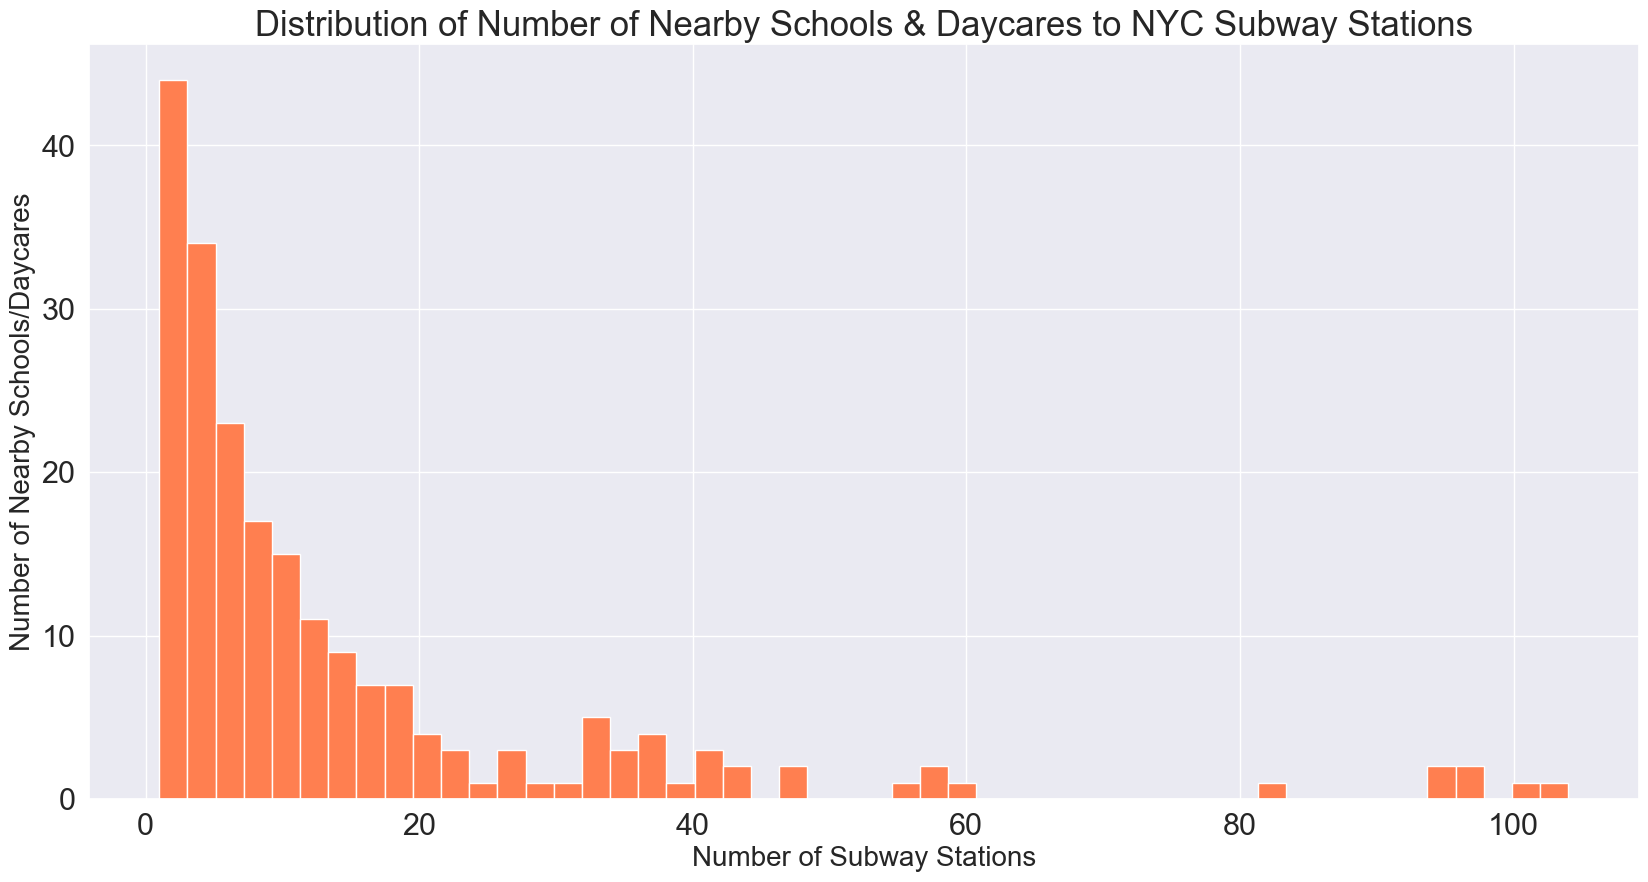

In [103]:
plt.figure(figsize=(20,10))
plt.hist(close_together_counts.number_of_close_facilities, bins=50, color = 'coral')

plt.title('Distribution of Number of Nearby Schools & Daycares to NYC Subway Stations', fontsize=25)
plt.xlabel('Number of Subway Stations', fontsize=20)
plt.ylabel('Number of Nearby Schools/Daycares', fontsize=20)

In [104]:
counts_and_ridership = pd.merge(close_together_counts, weekdays, left_on='station_name_proximity_df', right_on='station')

In [105]:
counts_and_ridership

station_name_proximity_df  number_of_close_facilities    ca  unit  \
0                      170 ST - 4                         104  R284  R243   
1                      170 ST - 4                         104  R284  R243   
2                      170 ST - 4                         104  R284  R243   
3                      170 ST - 4                         104  R284  R243   
4                      170 ST - 4                         104  R284  R243   
...                           ...                         ...   ...   ...   
3043696       ROOSEVELT ISLND - F                           1  N602  R259   
3043697       ROOSEVELT ISLND - F                           1  N602  R259   
3043698       ROOSEVELT ISLND - F                           1  N602  R259   
3043699       ROOSEVELT ISLND - F                           1  N602  R259   
3043700       ROOSEVELT ISLND - F                           1  N602  R259   

              scp              station line_name       date      time  \
0        00-00-00           170 ST - 4         4 2021-01-01  07:00:00   
1        00-00-00           170 ST - 4         4 2021-01-01  11:00:00   
2        00-00-00           170 ST - 4         4 2021-01-01  15:00:00   
3        00-00-00           170 ST - 4         4 2021-01-01  19:00:00   
4        00-00-00           170 ST - 4         4 2021-01-01  23:00:00   
...           ...                  ...       ...        ...       ...   
3043696  00-05-01  ROOSEVELT ISLND - F         F 2021-09-03  04:00:00   
3043697  00-05-01  ROOSEVELT ISLND - F         F 2021-09-03  08:00:00   
3043698  00-05-01  ROOSEVELT ISLND - F         F 2021-09-03  12:00:00   
3043699  00-05-01  ROOSEVELT ISLND - F         F 2021-09-03  16:00:00   
3043700  00-05-01  ROOSEVELT ISLND - F         F 2021-09-03  20:00:00   

            desc   entries     exits           date_time  \
0        REGULAR  50884828  50999235 2021-01-01 07:00:00   
1        REGULAR  50884896  50999272 2021-01-01 11:00:00   
2        REGULAR  50884966  50999322 2021-01-01 15:00:00   
3        REGULAR  50885036  50999417 2021-01-01 19:00:00   
4        REGULAR  50885073  50999449 2021-01-01 23:00:00   
...          ...       ...       ...                 ...   
3043696  REGULAR         0       160 2021-09-03 04:00:00   
3043697  REGULAR         0       160 2021-09-03 08:00:00   
3043698  REGULAR         0       160 2021-09-03 12:00:00   
3043699  REGULAR         0       160 2021-09-03 16:00:00   
3043700  REGULAR         0       160 2021-09-03 20:00:00   

         entries_since_last_audit  exits_since_last_audit  \
0                            15.0                     7.0   
1                            68.0                    37.0   
2                            70.0                    50.0   
3                            70.0                    95.0   
4                            37.0                    32.0   
...                           ...                     ...   
3043696                       0.0                     0.0   
3043697                       0.0                     0.0   
3043698                       0.0                     0.0   
3043699                       0.0                     0.0   
3043700                       0.0                     0.0   

         real_entries_since_audit  real_exits_since_audit  day_of_week  \
0                            15.0                     7.0            4   
1                            68.0                    37.0            4   
2                            70.0                    50.0            4   
3                            70.0                    95.0            4   
4                            37.0                    32.0            4   
...                           ...                     ...          ...   
3043696                       0.0                     0.0            4   
3043697                       0.0                     0.0            4   
3043698                       0.0                     0.0            4   
3043699     

In [106]:
print(counts_and_ridership.station_avg_daily_ridership.max())
print(counts_and_ridership.station_avg_daily_ridership.median())
counts_and_ridership.groupby(['station', 'number_of_close_facilities'
                                ])[['station_avg_daily_ridership']].max().sort_values(by='number_of_close_facilities',
                                                                                     ascending=False)

36918.86628964099
5430.927785315845


station_avg_daily_ridership
station                 number_of_close_facilities                             
170 ST - 4              104                                         4009.514098
FORDHAM RD - BD         100                                         3496.105645
BURNSIDE AV - 4         97                                          3075.665219
167 ST - 4              97                                          4921.591063
KINGSBRIDGE RD - BD     95                                          3209.649935
...                                                                         ...
59 ST COLUMBUS - ABCD1  1                                          15141.943798
34 ST-HUDSON YD - 7     1                                           7300.689891
34 ST-PENN STA - 123ACE 1                                          13715.410390
42 ST-BRYANT PK - BDFM7 1                                          10755.844766
FOREST HILLS 71 - EFMR  1                                           5848.434298

[211 rows x 1 columns]

Text(0.5, 1.0, 'Ridership and Proximity to Childcare Facilities at NYC Subway Stations')

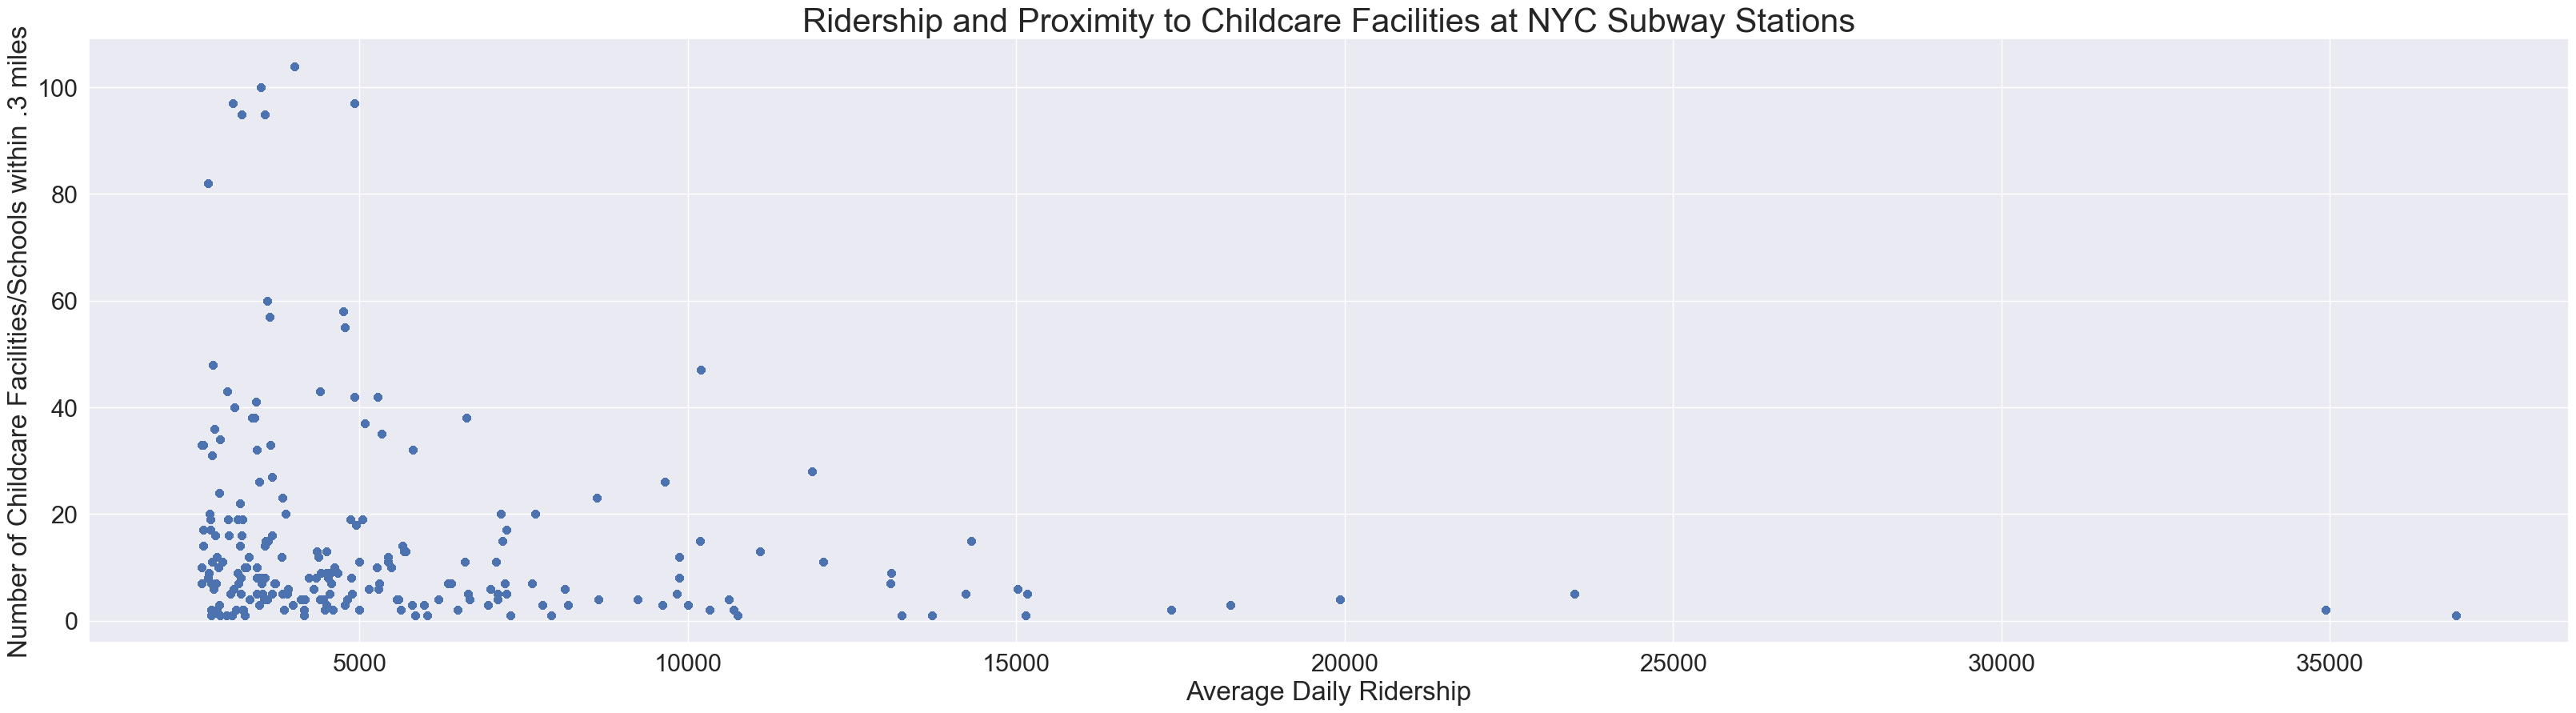

In [107]:
plt.scatter(counts_and_ridership.station_avg_daily_ridership, counts_and_ridership.number_of_close_facilities)
plt.xlabel('Average Daily Ridership')
plt.ylabel('Number of Childcare Facilities/Schools within .3 miles')
plt.title('Ridership and Proximity to Childcare Facilities at NYC Subway Stations', fontsize=30)

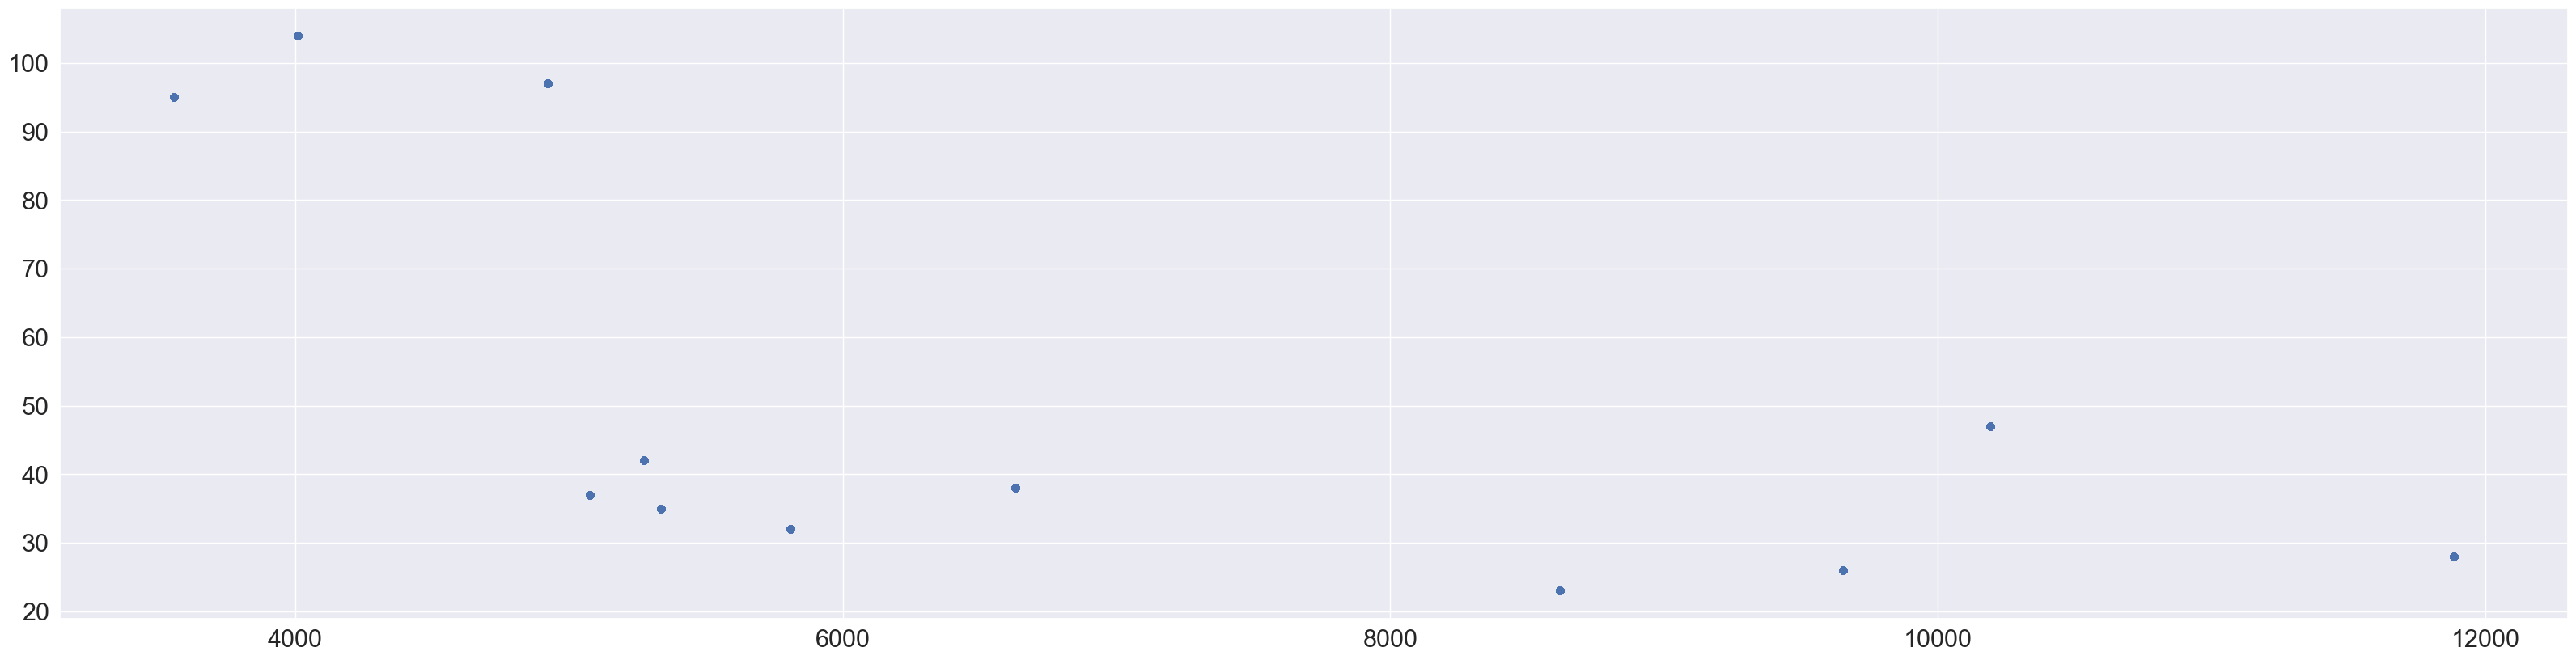

In [108]:
best_options = counts_and_ridership[((counts_and_ridership.station_avg_daily_ridership>5000) &
                                   (counts_and_ridership.number_of_close_facilities>20)) | 
                                   ((counts_and_ridership.number_of_close_facilities>80) &
                                    (counts_and_ridership.station_avg_daily_ridership>3500))]

#also including lower-ridershp stations with huge facilities 
#numbers becuse they'll get exposure to those who may not come from the subway
plt.scatter(best_options.station_avg_daily_ridership, best_options.number_of_close_facilities)

In [109]:
grouped_best_options = best_options.groupby('station', as_index=False)[['number_of_close_facilities', 
                                 'station_avg_daily_ridership']].max().sort_values('station_avg_daily_ridership', ascending=False)
grouped_best_options

station  number_of_close_facilities  \
2            125 ST - 456                          28   
4           145 ST - ABCD                          47   
9   DELANCEY/ESSEX - FJMZ                          26   
10          GRAND ST - BD                          23   
8        3 AV-149 ST - 25                          38   
0              103 ST - 6                          32   
3     137 ST CITY COL - 1                          35   
7              181 ST - A                          42   
1              116 ST - 6                          37   
5              167 ST - 4                          97   
6              170 ST - 4                         104   
11        TREMONT AV - BD                          95   

    station_avg_daily_ridership  
2                  11886.495650  
4                  10193.049457  
9                   9652.643205  
10                  8618.357083  
8                   6631.727738  
0                   5807.738983  
3                   5336.948315  
7                   5273.983811  
1                   5074.432359  
5                   4921.591063  
6                   4009.514098  
11                  3556.778222

## Time of Day

In [110]:
station_options = best_options.station.unique()

In [111]:
time_of_day = filtered_df[np.isin(filtered_df.station, station_options)]

In [132]:


midnight, four, eight, noon, sixteen, twenty, twentyfour = dt.time(0,0), dt.time(4,0), dt.time(8,0), dt.time(12,0), dt.time(16,0), dt.time(20,0), dt.time(23,59)


time_block_list = []
for time in time_of_day.time:
    if (time >= midnight) & (time < four):
        time_block_list.append('00:00 - 04:00')
    elif (time >= four) & (time < eight):
        time_block_list.append('04:00 - 08:00')
    elif (time >= eight) & (time < noon):
        time_block_list.append('08:00 - 12:00')
    elif (time >= noon) & (time < sixteen):
        time_block_list.append('12:00 - 16:00')
    elif (time >= sixteen) & (time < twenty):
        time_block_list.append('16:00 - 20:00')
    elif (time >= twenty) & (time <= twentyfour):
        time_block_list.append('20:00 - 24:00')


time_of_day['time_block'] = time_block_list

      
grouped_time = time_of_day.groupby(['station','time_block'], as_index=False)[['real_exits_since_audit']].mean()
grouped_time.head(5)




<ipython-input-132-4ce5c3b5b32f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_of_day['time_block'] = time_block_list


station     time_block  real_exits_since_audit
0  103 ST - 6  00:00 - 04:00               93.980272
1  103 ST - 6  04:00 - 08:00               13.976287
2  103 ST - 6  08:00 - 12:00              201.484480
3  103 ST - 6  12:00 - 16:00              202.753388
4  103 ST - 6  16:00 - 20:00              237.631973

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Average Station Ridership per Time Period')

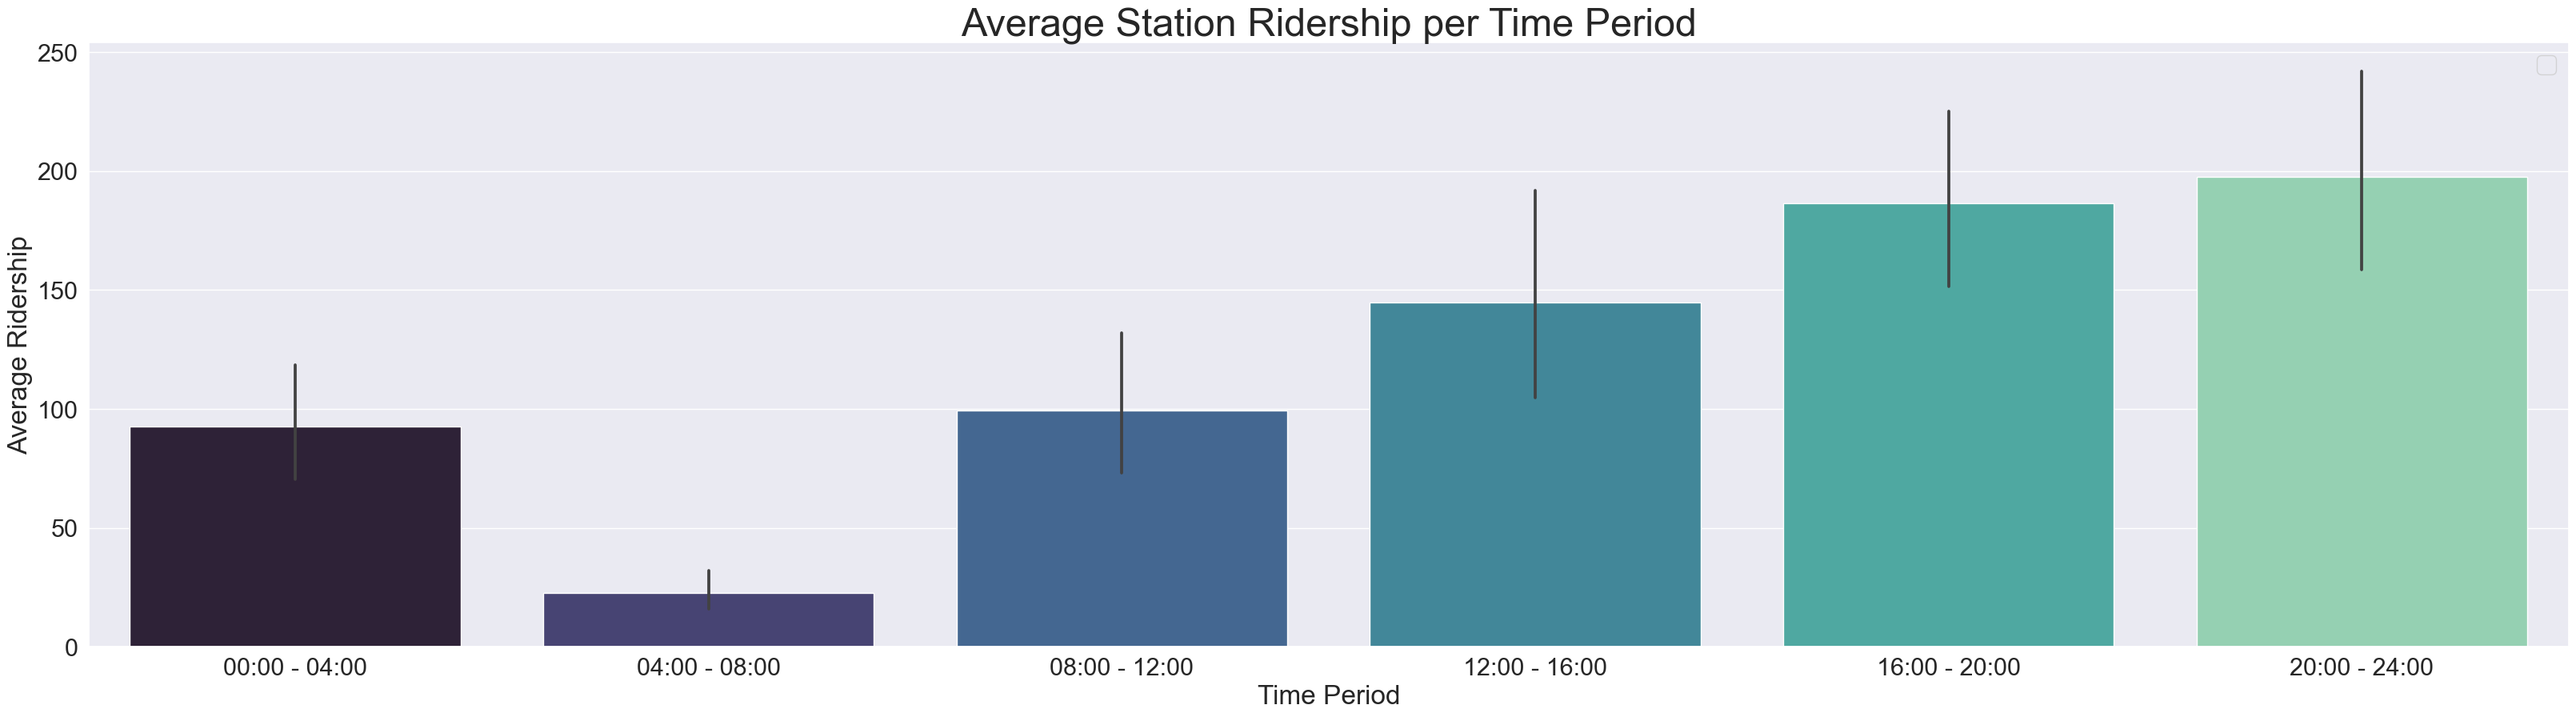

In [119]:
time_periods = sns.barplot(data=grouped_time, x='time_block', y='real_exits_since_audit', palette= 'mako')
plt.legend(loc='upper right')
plt.ylabel('Average Ridership')
plt.xlabel('Time Period')
plt.title('Average Station Ridership per Time Period', fontsize=35)


Text(0.5, 1.0, 'Average Ridership by Station per Time Period')

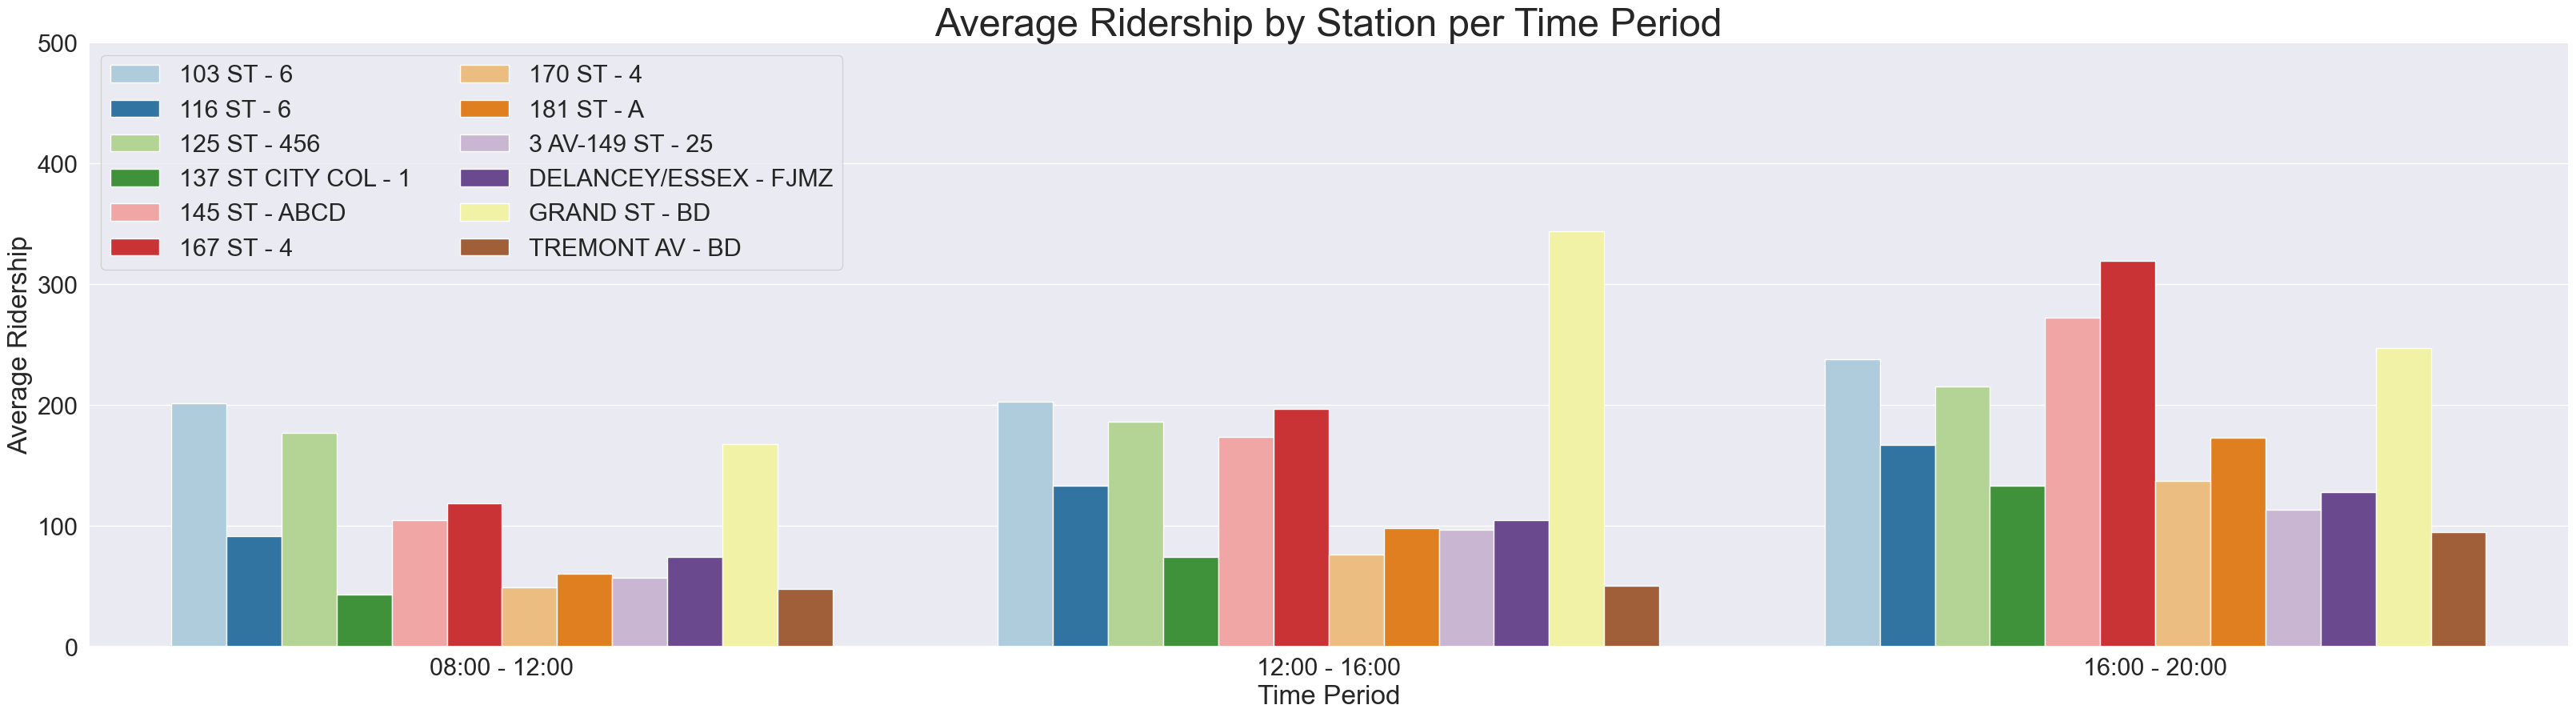

In [130]:
grouped_daytime = grouped_time[(grouped_time.time_block == '08:00 - 12:00') |
                              (grouped_time.time_block == '12:00 - 16:00')|
                              (grouped_time.time_block == '16:00 - 20:00')]
time_periods = sns.barplot(data=grouped_daytime, x='time_block', y='real_exits_since_audit', hue='station', palette = 'Paired')


plt.legend(loc='best', ncol=2)
plt.ylim(top=500)
plt.xlabel('Time Period')
plt.ylabel('Average Ridership')
plt.title('Average Ridership by Station per Time Period', fontsize=35)

# Mapping?

In [115]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

station_options = best_options.station.unique()

stations_to_map = station_coords[np.isin(station_coords.station, station_options)]

flipped_coord_list = []
for item in stations_to_map.coordinate:
    flipped_coord_list.append(item[::-1])
stations_to_map['flipped_coord'] = flipped_coord_list

stations_to_map['geometry'] = [Point(xy) for xy in stations_to_map.flipped_coord]



school_nursery_mask = close_together.school_daycare[np.isin(close_together.station, station_options)]
schools_nurserys_to_map = schools_daycares[np.isin(schools_daycares.facility_name,school_nursery_mask)]


flipped_coord_list_school = []
for item in schools_nurserys_to_map.coordinate:
    flipped_coord_list_school.append(item[::-1])
schools_nurserys_to_map['flipped_coord'] = flipped_coord_list_school

schools_nurserys_to_map['geometry'] = [Point(xy) for xy in schools_nurserys_to_map.flipped_coord]

stations_to_map = gpd.GeoDataFrame(stations_to_map, geometry='geometry')
schools_nurserys_to_map = gpd.GeoDataFrame(schools_nurserys_to_map, geometry='geometry')

schools_nurserys_to_map



                                           

<ipython-input-115-1442a0608313>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_to_map['flipped_coord'] = flipped_coord_list
<ipython-input-115-1442a0608313>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_to_map['geometry'] = [Point(xy) for xy in stations_to_map.flipped_coord]
<ipython-input-115-1442a0608313>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

facility_name   latitude  longitude  \
13                           Calderon, Benita  40.851936 -73.907683   
126                      Ramkoomar, Lilmattie  40.852241 -73.902124   
131                        Heredia, Francisca  40.718973 -73.992404   
196        SCAN-NY at Harbor Science and Arts  40.795555 -73.944602   
204                             Parra, Carmen  40.841498 -73.915477   
...                                       ...        ...        ...   
2005  Bronx Academy of Promise Charter School  40.839503 -73.919597   
2057             Rosalyn Yalow Charter School  40.836679 -73.917350   
2107            Mount Eden Children's Academy  40.842503 -73.916084   
2137            Brilla Veritas Charter School  40.815311 -73.921481   
2179       Family Life Academy Charter School  40.840262 -73.918665   

                   coordinate            flipped_coord  \
13    (40.851936, -73.907683)  (-73.907683, 40.851936)   
126   (40.852241, -73.902124)  (-73.902124, 40.852241)   
131   (40.718973, -73.992404)  (-73.992404, 40.718973)   
196   (40.795555, -73.944602)  (-73.944602, 40.795555)   
204   (40.841498, -73.915477)  (-73.915477, 40.841498)   
...                       ...                      ...   
2005  (40.839503, -73.919597)  (-73.919597, 40.839503)   
2057   (40.836679, -73.91735)   (-73.91735, 40.836679)   
2107  (40.842503, -73.916084)  (-73.916084, 40.842503)   
2137  (40.815311, -73.921481)  (-73.921481, 40.815311)   
2179  (40.840262, -73.918665)  (-73.918665, 40.840262)   

                        geometry  
13    POINT (-73.90768 40.85194)  
126   POINT (-73.90212 40.85224)  
131   POINT (-73.99240 40.71897)  
196   POINT (-73.94460 40.79556)  
204   POINT (-73.91548 40.84150)  
...                          ...  
2005  POINT (-73.91960 40.83950)  
2057  POINT (-73.91735 40.83668)  
2107  POINT (-73.91608 40.84250)  
2137  POINT (-73.92148 40.81531)  
2179  POINT (-73.91867 40.84026)  

[563 rows x 6 columns]

In [116]:
nyc_map = gpd.read_file('geo_export_4807c9ac-5ab4-496e-aee1-c17d9d79dd8e.shp')

In [117]:

nyc_map.geometry = nyc_map.geometry.set_crs(epsg=4326, allow_override=True)
print(nyc_map.crs)
nyc_map.geometry.head()


epsg:4326


0    POLYGON ((-73.74251 40.59909, -73.74259 40.599...
1    POLYGON ((-73.92091 40.55837, -73.92092 40.558...
2    POLYGON ((-73.79829 40.59817, -73.79837 40.598...
3    POLYGON ((-73.87743 40.56522, -73.87749 40.565...
4    POLYGON ((-73.80335 40.58943, -73.80343 40.589...
Name: geometry, dtype: geometry

<AxesSubplot:title={'center':'NYC Subway Stations with High Ridership in Close Proximity to Schools & Daycares'}>

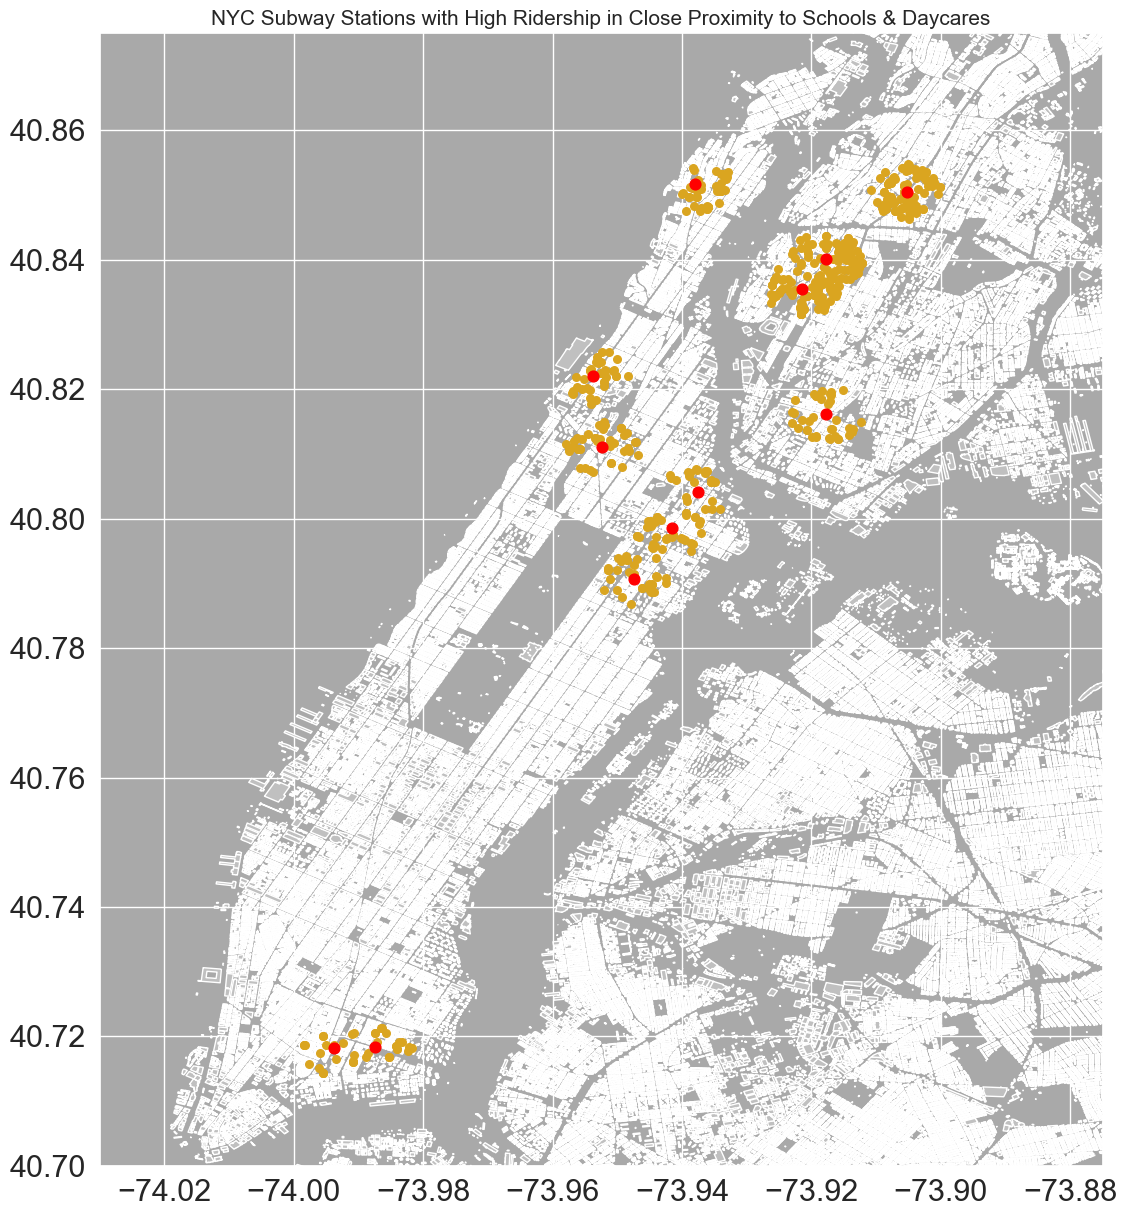

In [118]:
fig,ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, color='silver')
ax.set_xlim(left=-74.03, right=-73.875)
ax.set_ylim(bottom=40.7, top=40.875)
ax.set_facecolor('darkgrey')
ax.set_title('NYC Subway Stations with High Ridership in Close Proximity to Schools & Daycares', fontsize=15)



schools_nurserys_to_map.plot(ax=ax, markersize=30, color="goldenrod", marker="o", label="School or Daycare")
stations_to_map.plot(ax=ax, markersize=60, color="red", marker="o", label="Subway Station")
